In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib import image as mpimg
import math
from scipy.optimize import curve_fit
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
import os
import matplotlib.colors as mcolors
import pickle
from PIL import Image

#from ipynb.fs.full.functions_for_creating_plots import *
#%run functions_for_creating_plots.ipynb
os.chdir(os.getcwd())

### Define functions for loading the appropriate dataframe and adjust ligand concentration for the given koff/kon ratio

In [3]:
## Adjust ligand concentration with the Koff and Kon values in order to shift the DR-curves along the x-axis, 
# because of the change in the Kd values of the ligand caused by the changed Koff.Kon value from the default values (koff=0.0003,kon=0.3)
def adjust_ligand_ccs(ligand_ccs,koff,kon):
    Kd_ratio = (koff/ kon) / (0.0003 / 0.3)
    ligands = ligand_ccs * Kd_ratio
    return (ligands)

## Get filename of .csv 
def load_dataframe(dirname,process_name,ligand,kon,koff,molecules_dict,molecule,factor=None):
    
    if factor!=None:
        fname=dirname+ '_'.join([process_name,str(factor),'koff',str(koff),'kon',str(kon),'ligand_cc',str(round(ligand,3))]) + '.csv'
    if factor==None:
        fname=dirname+ '_'.join([process_name,'koff',str(koff),'kon',str(kon),'ligand_cc',str(round(ligand,3))]) + '.csv'

    col_nums=[int(x+1) for x in molecules_dict[molecule]]
    col_nums.append(0)
    mol_ccs_df=pd.read_csv(fname, index_col=0,usecols=col_nums)
    return mol_ccs_df

### Check if 'article_figure' folder exist -> if not create it

In [6]:
def create_folder_if_doesnt_exist(path):
    if not os.path.exists(path):
        print('folder created: ',path)
        os.makedirs(path)
    return

## Create article_figure and temp_data_for_plotting folder
path='../data/article_figure'
if not os.path.exists(path):
    print('folder created: '+ path)
    print()
    os.makedirs(path)
    
path='../data/article_figure/temp_data_for_plotting'
if not os.path.exists(path):
    print('folder created: '+ path)
    print()
    os.makedirs(path)



### Define plot layout, high and low koff value

In [7]:
## Dictionary holding the numbers of the molecules in the model (for explanation, look up model-figure.pdf)
molecules_dict={'$\mathbf{G_{GTP}}$':[23,33],
                '$\mathbf{IP_{3}}$':[40],
                'Total Arrestin-Receptor':[10,11,12,13,14,15],
                'PM Arrestin-Receptor':[10,11,12],
                'IC Arrestin-Receptor':[13,14,15]}

## Determine ligand concentrations              
ligand_ccs=(10 ** np.arange(-6, 1.1, 1))
internalisation_status=['With_internalisation','No_internalisation']

## Simulation time
simulation_time=1200

## High Koff: create figure with both high Koff==0.03 and Koff==0.3
high_koff=0.03
low_koff=0.0003

## Set folder names for saveing temporary data into temp_dirname
temp_dirname='../data/article_figure/temp_data_for_plotting'

## DIRECTORY NAME FOR THE FINAL PLOT
final_dirname='../data/article_figure'

## Create layout for subplot_mosaic function
subplot_layout=[['A','B','C','D'],
                ['E_up','F_up','G_up','H_up'],
                ['E_low','F_low','G_low','H_low'],
                ['I','J','K_up','K_up'],
                ['I','J','K_low','K_low']]#,
                #['M','M','M','M']]


## __A : add any kind of graphic (.png is the easiset) to subplot A__

In [52]:
def add_graphic_to_subplot_a(subplot_name,subplot_label,img_path,ax,fig_width,fig_height,subplot_label_fontsize_nominator,subplot_height,subplot_width):

    ## Define which subplot we eant to plot into from the original subplot_mosaic object
    axis=ax[subplot_name]
    
    ## Set background to white
    #axis.set_axis_bgcolor('white')
    axis.axis("off")

    ## Resize and show image in the subplot
    img=Image.open(img_path)
    newsize=(int(subplot_width), int(subplot_height))
    resized_img=img.resize(newsize)
    plot=axis.imshow(resized_img)

    ## Calculate plot area first -> this is used to set the fontsizes and linewidth of the plots by fontsize=plot_area/fontsize_nominator ->
    plot_area=fig_width*fig_height
    
    axis.text(-0.1, 1.05,subplot_label.lower(),weight='bold',size=plot_area/subplot_label_fontsize_nominator,transform=axis.transAxes)

    return plot

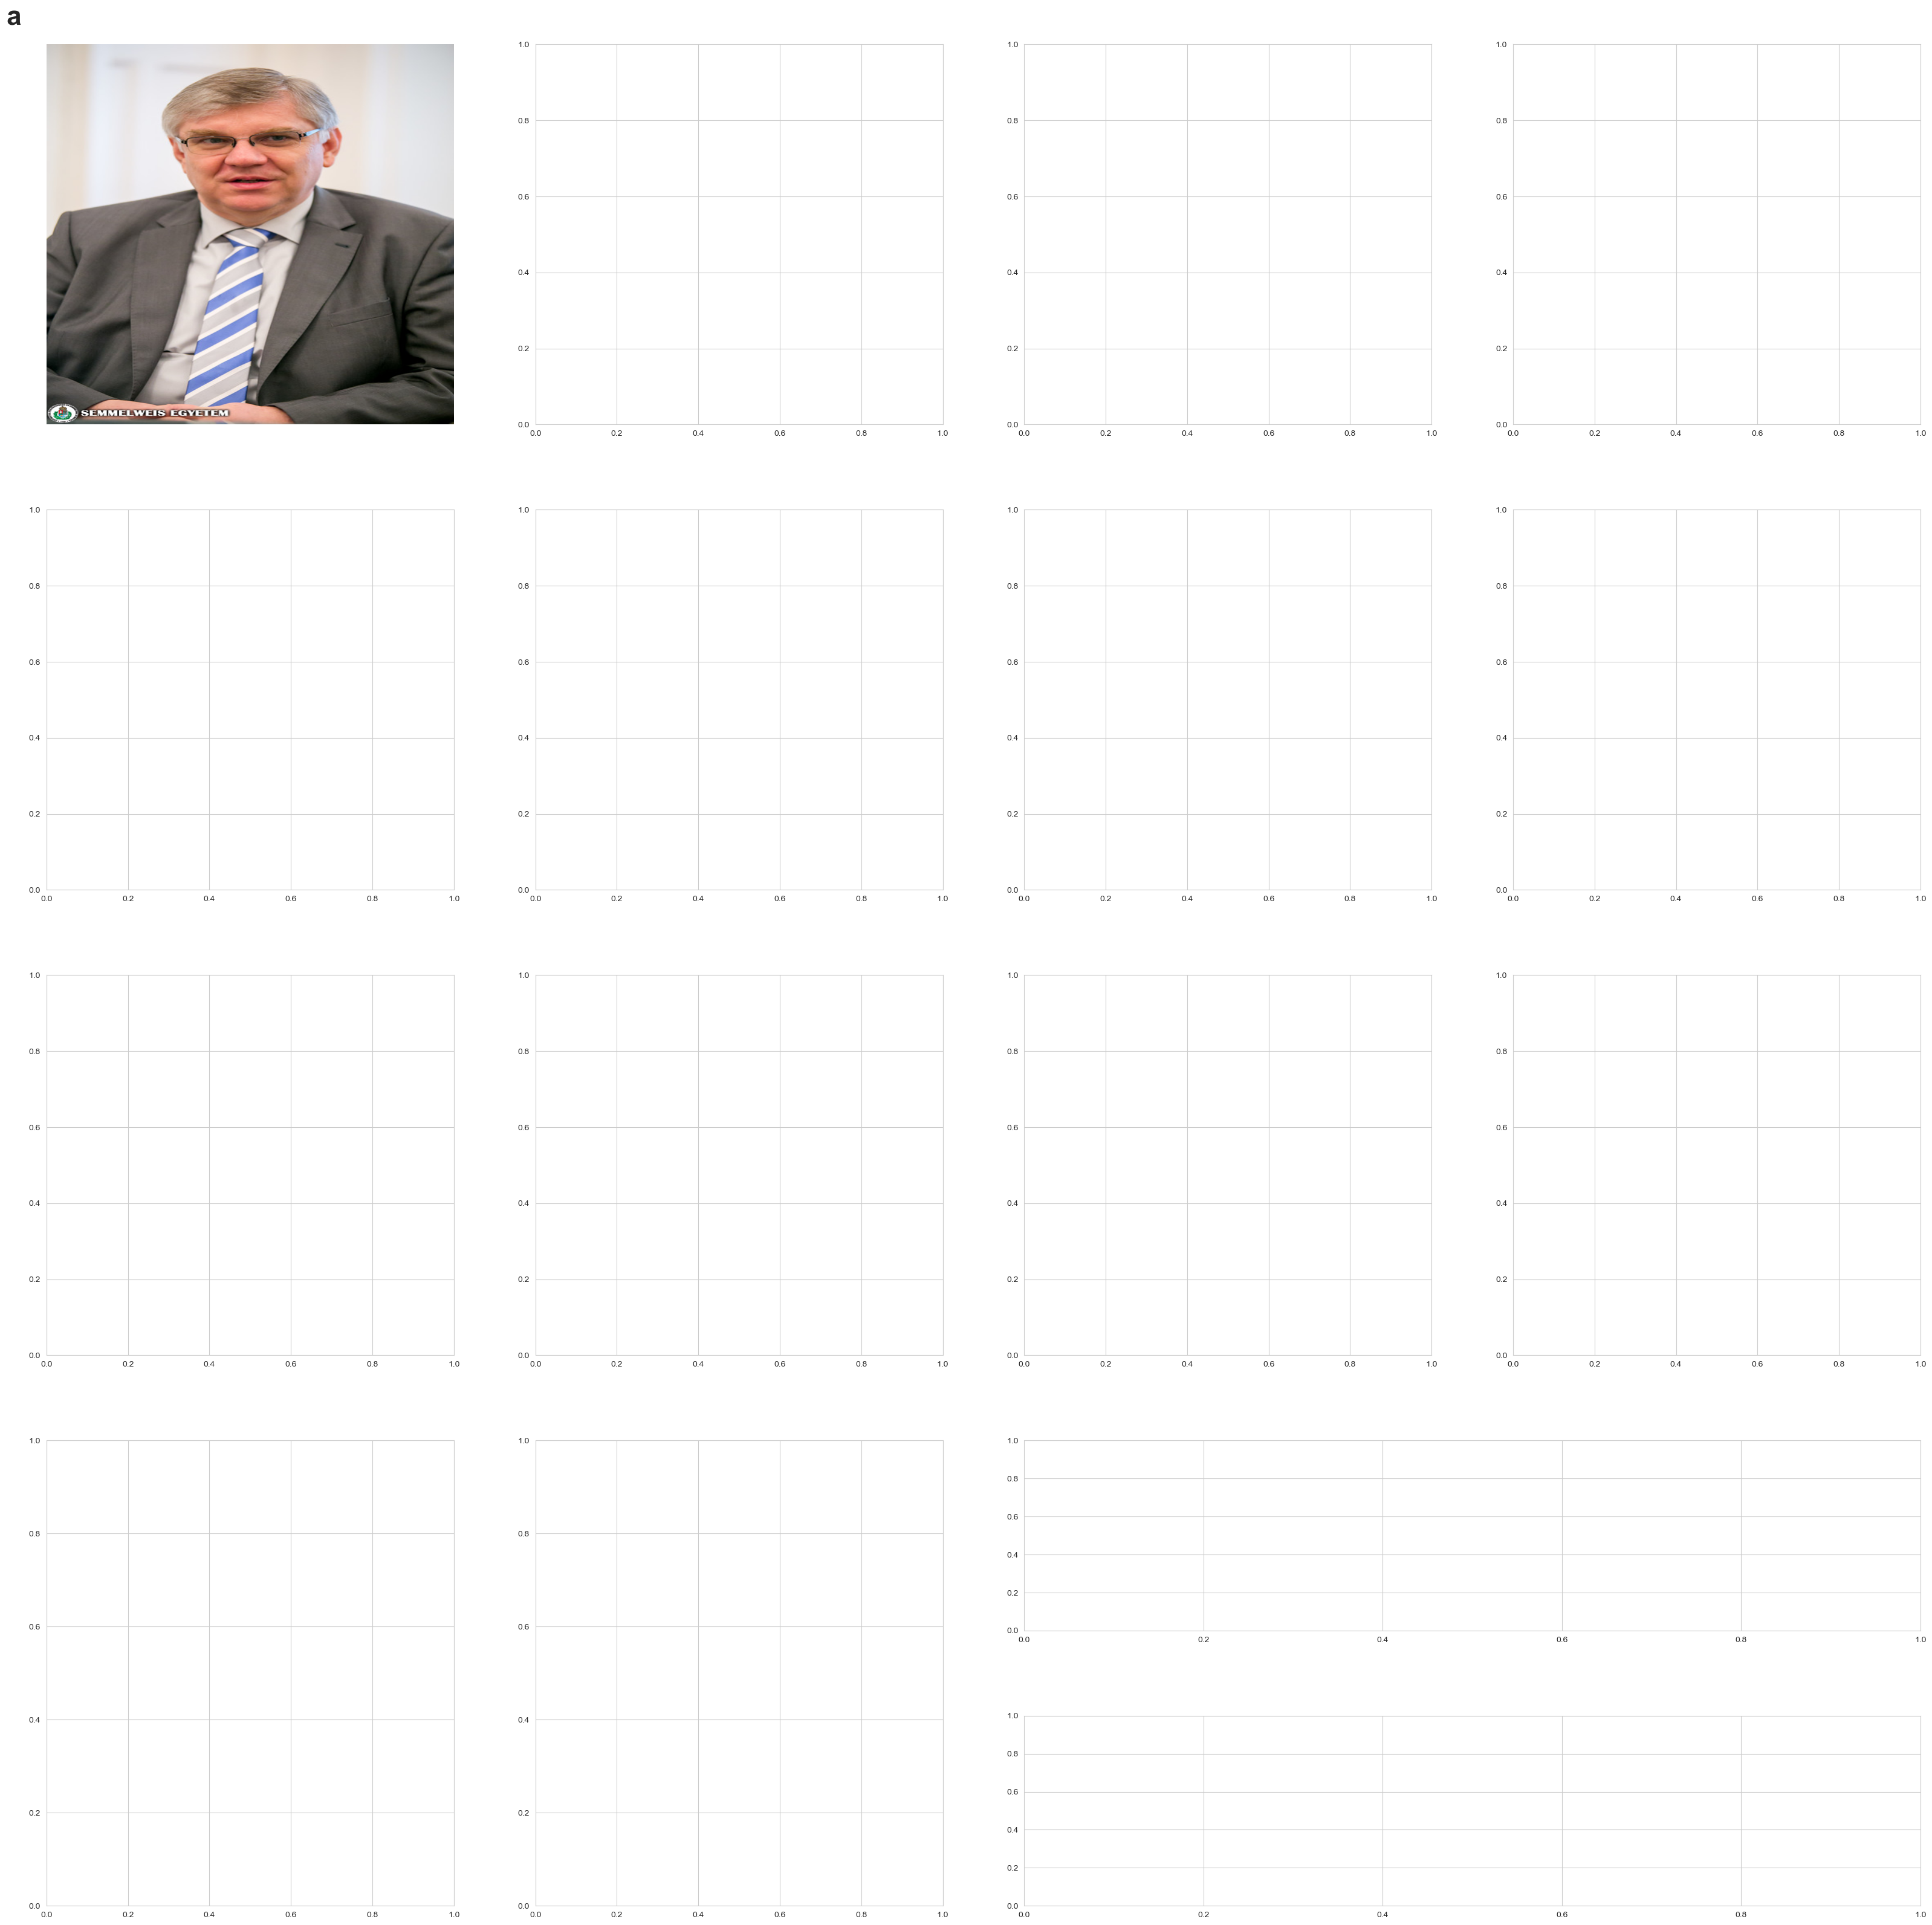

In [58]:
## Define subplots and molecules to plot
subplots_names=['A']
subplot_labels=['A']

## Set figure size
fig_width=40
fig_height=40

## Create figure with empty subplots
fig,ax=plt.subplot_mosaic(subplot_layout,figsize=(fig_width,fig_height),gridspec_kw={'hspace':0.28,'height_ratios': [1,1, 1,0.5,0.5]})

## path of image to use (.png or .jpeg)
img_path=os.path.join(temp_dirname,'subplot_a_graphic.png')
img_path=os.path.join(temp_dirname,'subplot_a_graphic.jpeg')

## Resize image if you want -> default is to resize it subplot bounding box
subplot_height, subplot_width = ax['A'].bbox.height, ax['A'].bbox.width

## Set size of subplot label font
subplot_label_fontsize_nominator=50

for subplot_name,subplot_label in zip(subplots_names,subplot_labels):
    ax[subplot_name]=add_graphic_to_subplot_a(subplot_name,subplot_label,img_path,ax,fig_width,fig_height,subplot_label_fontsize_nominator,\
                                                subplot_height,subplot_width)

## Save fig and axes object for later to add more subplots to it
with open(os.path.join(temp_dirname,'temporary_plot_A_fig_object.pkl'),'wb') as file:
    pickle.dump(fig,file)
with open(os.path.join(temp_dirname,'temporary_plot_A_axes_object.pkl'),'wb') as file:
    pickle.dump(ax,file)

## __B - D__ Add plots for the first row (subplots **B - D**)
To be able to add additional subplots to the subplots_mosaic object later, plt.show() mustn't run plt.show() function and close the figure.
-> To prevent this plt.ioff() is run, but somehow it only takes effect after running this cell at least 2 times



In [56]:
def draw_kinetic_concentration_curve_of_molecule_with_different_ligand_ccs(molecule,molecules_dict,kon,koff,intern_status,process_name,ligand_ccs,\
                                                                           color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                                                                           subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                                                           subplot_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                                                                           legend_title,subplot_legend_title_fontsize_nominator,subplot_label,\
                                                                           subplot_label_fontsize_nominator,fig,exp_setup,koff_status,\
                                                                           linewidth_nominator):
    ## Create directory path to load the data from
    dirname=os.path.join('../data/',exp_setup,intern_status,process_name,'')

    ## Adjust ligand concentrations to used Kon and Koff values +  convert it from uM/L to M/L (by subtracting 6 from hte logarithmic values of ligand ccs)
    ligands=np.log10(adjust_ligand_ccs(ligand_ccs,koff,kon)) - 6

    ## Define which subplot we eant to plot into from the original subplot_mosaic object
    axis=ax[subplot_name]

    ## Calculate plot area first -> this is used to set the fontsizes and linewidth of the plots by fontsize=plot_area/fontsize_nominator ->
    plot_area=fig_width*fig_height
    
    ## Get color palette 
    colors = [color_palette_dict.get(col) for col in color_names]

    # Extract the maximum value of receptor-arrestin concentrations, in order to determine the common Y-axis range for the plots E-H
    arrestin_receptor_max_response=0
    
    # Set the linewidth for the curves
    linewidth=plot_area/linewidth_nominator

    ## Loop over the ligand concentrations, load the respective simulation data from the .csv file with only columns that contain data 
    #  for the molecule to be plotted
    for ligand,color in zip(ligands,colors):
        mol_ccs_df=load_dataframe(dirname,process_name,ligand,kon,koff,molecules_dict,molecule)
        plot=axis.plot(mol_ccs_df.index.tolist(),np.sum(mol_ccs_df.loc[:,:],1),label=round(ligand,1),color=color,linewidth=linewidth)
        ## Extract the maximum value of Arrestin-Receptor curves 
        if molecule=='Total Arrestin-Receptor' and max(np.sum(mol_ccs_df.loc[:,:],1))>arrestin_receptor_max_response:
            arrestin_receptor_max_response=max(np.sum(mol_ccs_df.loc[:,:],1))

    
    ## Customize legend, plot title, axis labels 
    axis.legend(title=legend_title,title_fontsize=plot_area/subplot_legend_title_fontsize_nominator,\
                fontsize=plot_area/subplot_legend_label_fontsize_nominator)
    
    axis_label_fontsize=plot_area/subplot_axis_label_fontsize_nominator
    axis_tick_labelsize=plot_area/subplot_axis_tick_label_fontsize_nominator

    title=koff_status#"$\mathbf{Low\ K_{off}}$"
    title_fontsize=plot_area/subplot_title_fontsize_nominator
    axis.set_title(title,fontsize=title_fontsize)

    axis.set_xlabel('Time (s)',fontweight="bold",fontsize=axis_label_fontsize)
    axis.set_ylabel(molecule,fontweight="bold",fontsize=axis_label_fontsize)
    axis.tick_params(axis='both', labelsize=axis_tick_labelsize)
    
    if 'Low' in koff_status:
        axis.text(-0.1, 1.05,subplot_label.lower(),weight='bold',size=plot_area/subplot_label_fontsize_nominator,transform=axis.transAxes)

    #fig.suptitle(expt_setup_suptitle,size=35)
    plt.tight_layout()
    return plot,arrestin_receptor_max_response

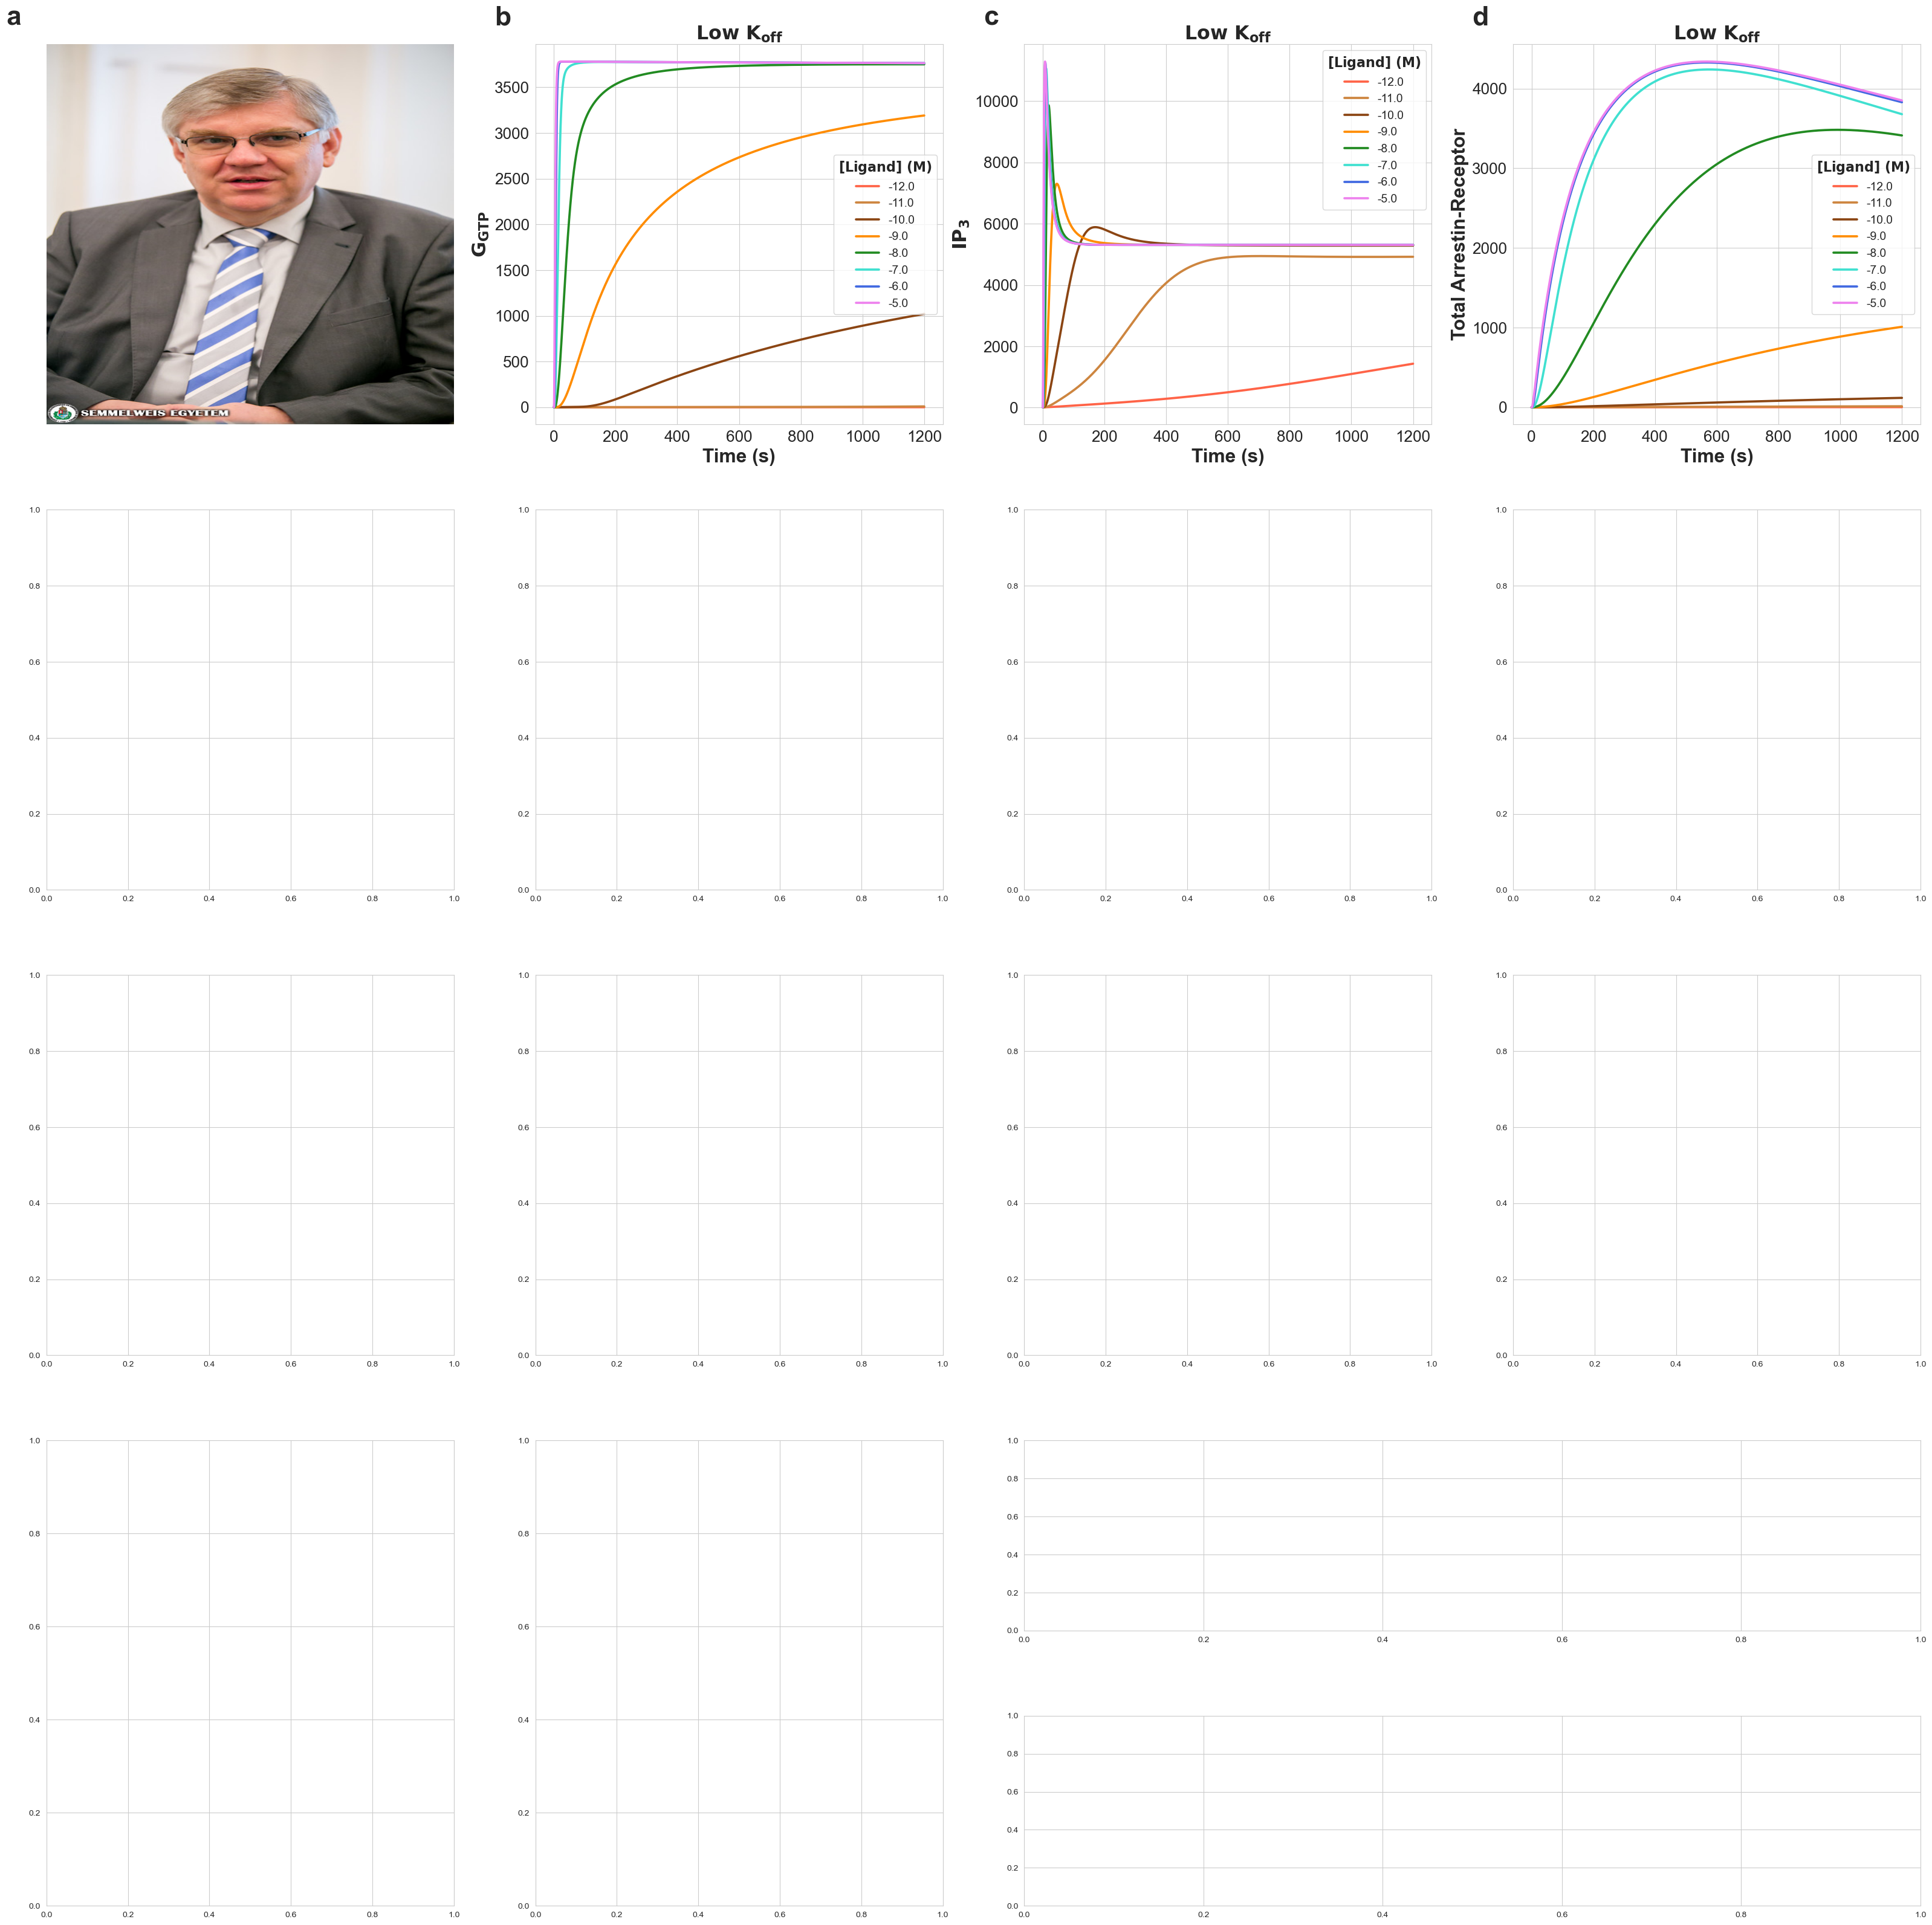

In [64]:
## Define subplots and molecules to plot
subplots_names=['B','C','D']
subplot_labels=['B','C','D']

molecules_to_plot=['$\mathbf{G_{GTP}}$','$\mathbf{IP_{3}}$','Total Arrestin-Receptor']

## Define the parameters for the plots
kon=0.3
koff=low_koff
ligand_ccs=(10 ** np.arange(-6, 1.1, 1))
intern_status='With_internalisation'
process_name='Koff_Kon_all'
color_palette_dict=mcolors.CSS4_COLORS
color_names=['tomato','peru','saddlebrown','darkorange','forestgreen','turquoise','royalblue','violet']


fig_width=40
fig_height=40

## Size of plot elements (fontsize, linewidth, dotsize...) are linked to the size of the figure, so in case of figure size is changed
# the sizes of these elements automatically change with it. 
# Exact calculation of these sizes:   size_of_element=fig_width*fig_height/element_size_nominator
subplot_label_fontsize_nominator=50
subplot_title_fontsize_nominator=70
subplot_axis_label_fontsize_nominator=70
subplot_axis_tick_label_fontsize_nominator=85
subplot_legend_label_fontsize_nominator=115
legend_title='$\mathbf{[Ligand]\ (M)}$'
subplot_legend_title_fontsize_nominator=100
linewidth_nominator=600


### Load the previosly ceated figur and axes object to plot to
with open(os.path.join(temp_dirname,'temporary_plot_A_fig_object.pkl'),'rb') as file:
    fig=pickle.load(file)
    plt.close()
with open(os.path.join(temp_dirname,'temporary_plot_A_axes_object.pkl'),'rb') as file:
    ax=pickle.load(file)

## List containing the experimental setups for the subplots b,c,d
experimental_setups_per_subplot=['receptor_gprotein_overexpression','receptor_overexpression','receptor_arrestin_overexpression']

for subplot_name,molecule,subplot_label,exp_setup in zip(subplots_names,molecules_to_plot,subplot_labels,experimental_setups_per_subplot):
    for koff,koff_status in zip([low_koff],['$\mathbf{Low\ K_{off}}$']):
            ax[subplot_name],arrestin_receptor_max_response=draw_kinetic_concentration_curve_of_molecule_with_different_ligand_ccs(molecule,molecules_dict,\
                                                                                kon,koff,intern_status,process_name,ligand_ccs,\
                                                                                color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                                                                                subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                                                                subplot_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                                                                                legend_title,subplot_legend_title_fontsize_nominator,subplot_label,\
                                                                                subplot_label_fontsize_nominator,fig,exp_setup,koff_status,\
                                                                                linewidth_nominator)
            
            ## Save maximal Total-Arrestin receptor values, in order to set the y-axis limit for the next plots
            if molecule=='Total Arrestin-Receptor':
                with open(os.path.join(temp_dirname,'arrestin_receptor_max_response.pkl'),'wb') as file:
                    pickle.dump(arrestin_receptor_max_response,file)


        
    ## Save fig and axes object for later to add more subplots to it
    with open(os.path.join(temp_dirname,'temporary_plot_A_D_fig_object.pkl'),'wb') as file:
        pickle.dump(fig,file)
    with open(os.path.join(temp_dirname,'temporary_plot_A_D_axes_object.pkl'),'wb') as file:
        pickle.dump(ax,file)



## **E - G** Add plots for the second and third row (**E - G**)

In [66]:
def draw_kinetic_concentration_curve_of_molecule_with_different_koff_values(molecule,molecules_dict,kon,koff_list,intern_status,process_name,ligand_ccs,\
                                                                           color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                                                                           subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                                                           subplot_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                                                                           legend_title,subplot_legend_title_fontsize_nominator,legend_handles,ylim,subplot_label,\
                                                                           subplot_label_fontsize_nominator,fig,exp_setup,linewidth_nominator):
    ## Create directory path to load the data from
    dirname=os.path.join('../data/',exp_setup,intern_status,process_name,'')

    ## Define which subplot we eant to plot into from the original subplot_mosaic object
    axis=ax[subplot_name]

    ## Get color palette 
    colors = [color_palette_dict.get(col) for col in color_names]

    ## Calculate plot area first -> this is used to set the fontsizes and linewidth of the plots by fontsize=plot_area/fontsize_nominator ->
    plot_area=fig_width*fig_height
    
    # Set the linewidth for the curves
    linewidth=plot_area/linewidth_nominator
    
    ## Loop over the ligand concentrations, load the respective simulation data from the .csv file
    for koff,color,label in zip(koff_list,colors,legend_handles):
        ## Adjust ligand concentrations to used Kon and Koff values +  convert it from uM/L to M/L (by subtracting 6 from hte logarithmic values of ligand ccs)
        ligands=np.log10(adjust_ligand_ccs(ligand_ccs,koff,kon)) - 6

        ## Add value of koff to the legend if you want
        #label=label + str(koff)

        for ligand in ligands:
            mol_ccs_df=load_dataframe(dirname,process_name,ligand,kon,koff,molecules_dict,molecule)
            plot=axis.plot(mol_ccs_df.index.tolist(),np.sum(mol_ccs_df.loc[:,:],1),label=label,color=color,linewidth=linewidth)
    
    ## Customize legend, plot title, axis labels 
    axis.legend(title=legend_title,title_fontsize=plot_area/subplot_legend_title_fontsize_nominator,\
                fontsize=plot_area/subplot_legend_label_fontsize_nominator)
    
    axis_label_fontsize=plot_area/subplot_axis_label_fontsize_nominator
    axis_tick_labelsize=plot_area/subplot_axis_tick_label_fontsize_nominator

    title_text=intern_status.replace('_','\ ')
    title=r"$\mathbf{{title}}$".replace('title',title_text)
 
    title_fontsize=plot_area/subplot_title_fontsize_nominator
    axis.set_title(title,fontsize=title_fontsize)

    axis.set_xlabel('Time (s)',fontweight="bold",fontsize=axis_label_fontsize)
    axis.set_ylabel(molecule,fontweight="bold",fontsize=axis_label_fontsize)
    axis.tick_params(axis='both', labelsize=axis_tick_labelsize)
    axis.set_ylim(0,ylim)

    ## If plot is in the upper row (=with internalistaion), then add plot label 
    if intern_status=='With_internalisation':
        axis.text(-0.1, 1.05,subplot_label.lower(),weight='bold',size=plot_area/subplot_label_fontsize_nominator,transform=axis.transAxes)

    plt.tight_layout()   
    return(plot)

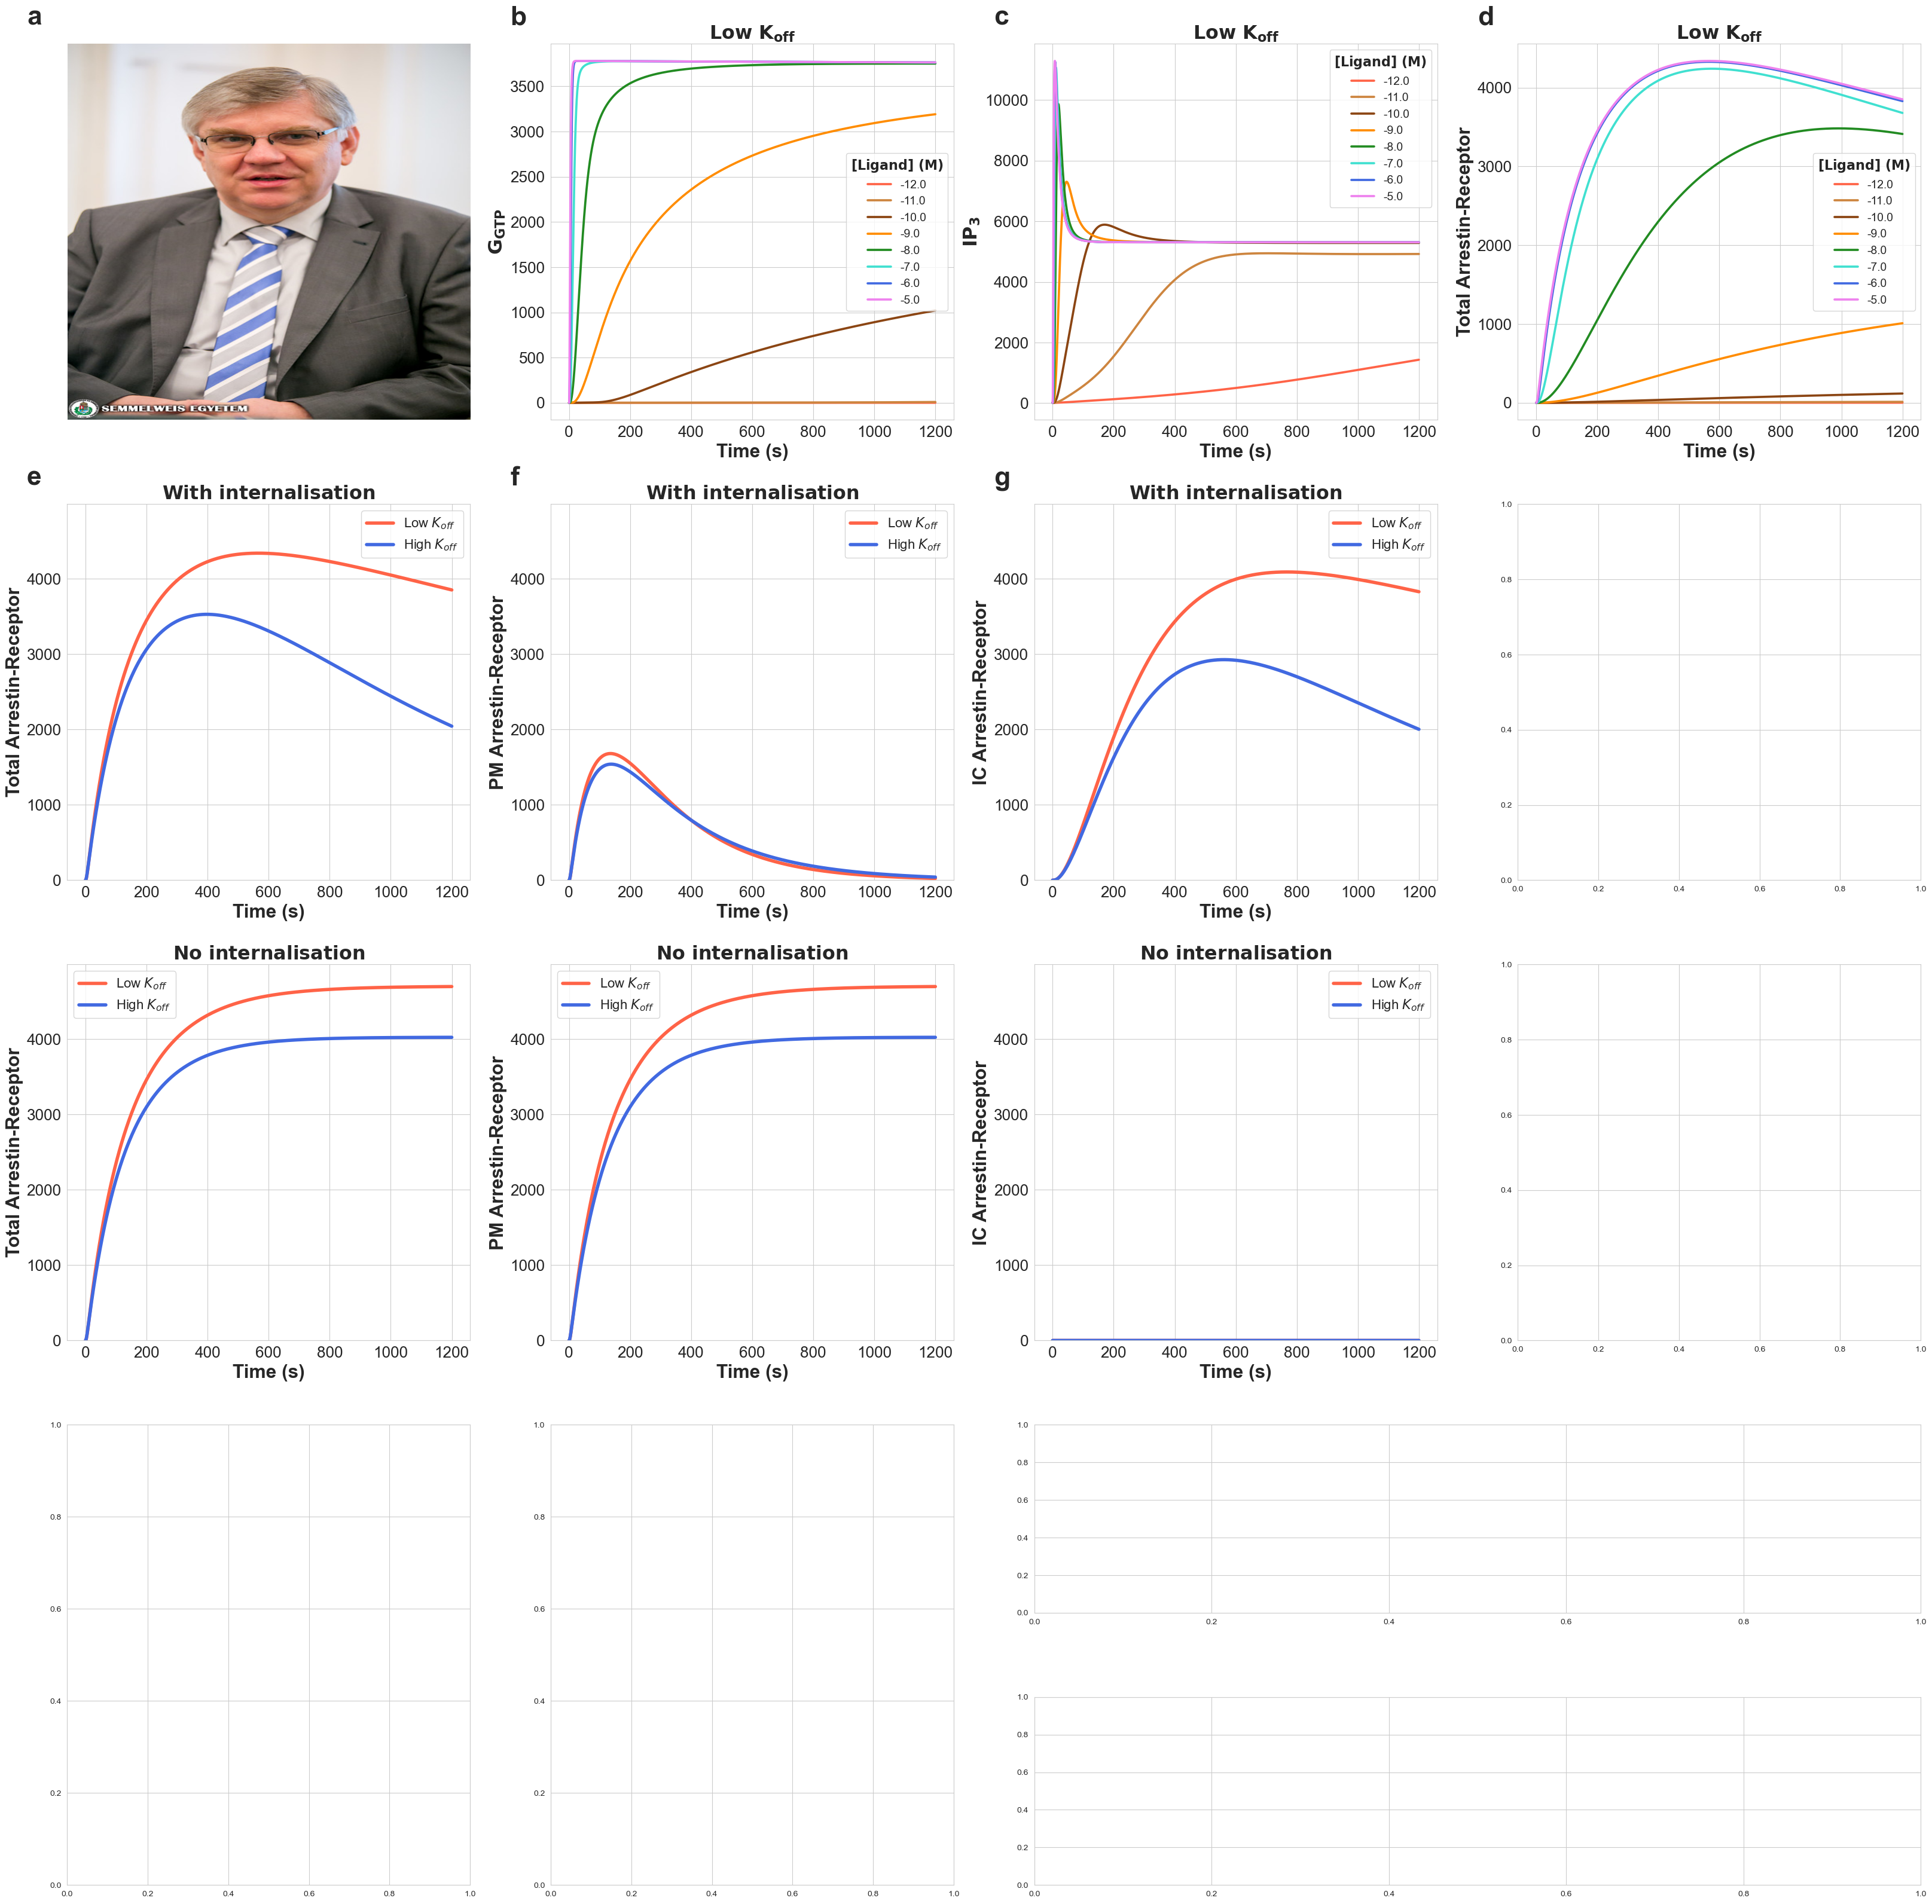

In [67]:
subplots_names=[['E_up','F_up','G_up'],
                ['E_low','F_low','G_low']]
subplot_labels=['E','F','G']
molecules_to_plot=['Total Arrestin-Receptor','PM Arrestin-Receptor','IC Arrestin-Receptor']

kon=0.3
koff_list=[low_koff,high_koff]
internalisation_status=['With_internalisation','No_internalisation']
process_name='Koff_Kon_all'
color_palette_dict=mcolors.CSS4_COLORS
color_names=['tomato','royalblue']#'peru','saddlebrown','darkorange','forestgreen','turquoise','royalblue','violet']

ligand_ccs=(10 ** np.arange(1, 1.1, 1))

fig_width=40
fig_height=40

#fig,ax=plt.subplot_mosaic(subplot_layout,figsize=(fig_width,fig_height))

## FOntsize=fig_width*fig_height/title_fontsize_ratio
subplot_label_fontsize_nominator=50
subplot_title_fontsize_nominator=70
subplot_axis_label_fontsize_nominator=70
subplot_axis_tick_label_fontsize_nominator=85
subplot_legend_label_fontsize_nominator=100
subplot_legend_title_fontsize_nominator=100
#legend_title='$\mathbf{K_{off}}$'
legend_title=None
legend_handles=['Low $K_{off}$','High $K_{off}$']
linewidth_nominator=400



#### Experimental setup for the plot
exp_setup='receptor_arrestin_overexpression'

### Load the previosly ceated figur and axes object to plot to
with open(os.path.join(temp_dirname,'temporary_plot_A_D_fig_object.pkl'),'rb') as file:
    fig=pickle.load(file)
    plt.close()
with open(os.path.join(temp_dirname,'temporary_plot_A_D_axes_object.pkl'),'rb') as file:
    ax=pickle.load(file)

## Set common y-axis limit for all the plots in E-H
with open(os.path.join(temp_dirname,'arrestin_receptor_max_response.pkl'),'rb') as file:
    arrestin_receptor_max_response=pickle.load(file)
    ylim=arrestin_receptor_max_response*1.15

for molecule,colnum,subplot_label in zip(molecules_to_plot,range(np.asarray(subplots_names).shape[1]),subplot_labels):
    for intern_status,rownum in zip(internalisation_status,range(np.asarray(subplots_names).shape[0])):
        subplot_name=subplots_names[rownum][colnum]
        ax[subplot_name]=draw_kinetic_concentration_curve_of_molecule_with_different_koff_values(molecule,molecules_dict,kon,koff_list,intern_status,\
                                                                        process_name,ligand_ccs,color_palette_dict,color_names,ax,subplot_name,\
                                                                        fig_width,fig_height,\
                                                                        subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                                                        subplot_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                                                                        legend_title,subplot_legend_title_fontsize_nominator,legend_handles,ylim,subplot_label,\
                                                                        subplot_label_fontsize_nominator,fig,exp_setup,linewidth_nominator)

## Save fig and axes object for later to add more subplots to it
with open(os.path.join(temp_dirname,'temporary_plot_A_G_fig_object.pkl'),'wb') as file:
    pickle.dump(fig,file)
with open(os.path.join(temp_dirname,'temporary_plot_A_G_axes_object.pkl'),'wb') as file:
    pickle.dump(ax,file)

## __H__ Add 2 DR-curve plots (__H__)

In [68]:
def draw_DR_points_plus_fit_DR_curve(molecule,molecules_dict,kon,koff_list,intern_status,process_name,ligand_ccs,\
                                    color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                                    subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                    subplot_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                                    legend_title,subplot_legend_title_fontsize_nominator,legend_handles,time_to_response,ylim,\
                                    subplot_label,subplot_label_fontsize_nominator,plot_dot_size_nominator,fig,exp_setup,
                                    linewidth_nominator):
    
    ## Create directory path to load the data from
    dirname=os.path.join('../data/',exp_setup,intern_status,process_name,'')

    ## Define which subplot we want to plot into from the original subplot_mosaic object
    axis=ax[subplot_name]

    ## Calculate plot area first -> this is used to set the fontsizes and linewidth of the plots by fontsize=plot_area/fontsize_nominator ->
    plot_area=fig_width*fig_height
    
    # Set the linewidth and dot size for the curves
    linewidth=plot_area/linewidth_nominator
    plot_dot_size=plot_area/plot_dot_size_nominator

    ## Get color palette 
    colors = [color_palette_dict.get(col) for col in color_names]
    
    ## Loop over the ligand concentrations, load the respective simulation data from the .csv file
    for koff,color,label in zip(koff_list,colors,legend_handles):
        ## Adjust ligand concentrations to used Kon and Koff values +  convert it from uM/L to M/L (by subtracting 6 from hte logarithmic values of ligand ccs)
        ligands=np.log10(adjust_ligand_ccs(ligand_ccs,koff,kon)) - 6

        ## Create list to save the Dose-Response concentrations of the molecule at the given timepoint for given Koff-kon value pair
        DR_points=[]
        label=label + str(koff)

        for ligand in ligands:
            mol_ccs_df=load_dataframe(dirname,process_name,ligand,kon,koff,molecules_dict,molecule)
            response_at_time=np.sum(mol_ccs_df.loc[time_to_response,:])
            DR_points.append(response_at_time)
        
        ## Function to fit DR curve on the DR-points extracted from the simulated data and return logEC50 for plotting the fitted DR curve
        def func(ligands, logec50):
            return max(DR_points) / (1 + 10 ** (logec50 - np.log10(ligands)))
        logec50, pcov = curve_fit(func, 10**ligands, DR_points,bounds=(-19,-1))

        ## Create x-axis values for DR curve
        ligandrange = np.linspace(ligands[0], ligands[-1], 100)
        axis.plot((ligandrange), func(10 ** ligandrange, logec50), color=color,linewidth=linewidth)
        axis.scatter(ligands, DR_points,label=label, color=color,s=plot_dot_size)
        
    ## Customize legend, plot title, axis labels 
  
    axis.legend(title=legend_title,title_fontsize=plot_area/subplot_legend_title_fontsize_nominator,\
                fontsize=plot_area/subplot_legend_label_fontsize_nominator)
    
    axis_label_fontsize=plot_area/subplot_axis_label_fontsize_nominator
    axis_tick_labelsize=plot_area/subplot_axis_tick_label_fontsize_nominator

    title_text=intern_status.replace('_','\ ')
    title=r"$\mathbf{{title}}$".replace('title',title_text)
 
    title_fontsize=plot_area/subplot_title_fontsize_nominator
    axis.set_title(title,fontsize=title_fontsize)

    axis.set_xlabel('log(Ligand) M ',fontweight="bold",fontsize=axis_label_fontsize)
    axis.set_ylabel(molecule,fontweight="bold",fontsize=axis_label_fontsize)
    axis.tick_params(axis='both', labelsize=axis_tick_labelsize)
    axis.set_ylim(0,ylim)

    ## If plot is in the upper row (=with internalistaion), then add plot label 
    if intern_status=='With_internalisation':
        axis.text(-0.1, 1.05,subplot_label.lower(),weight='bold',size=plot_area/subplot_label_fontsize_nominator,transform=axis.transAxes)

    plt.tight_layout()  
    return(axis)

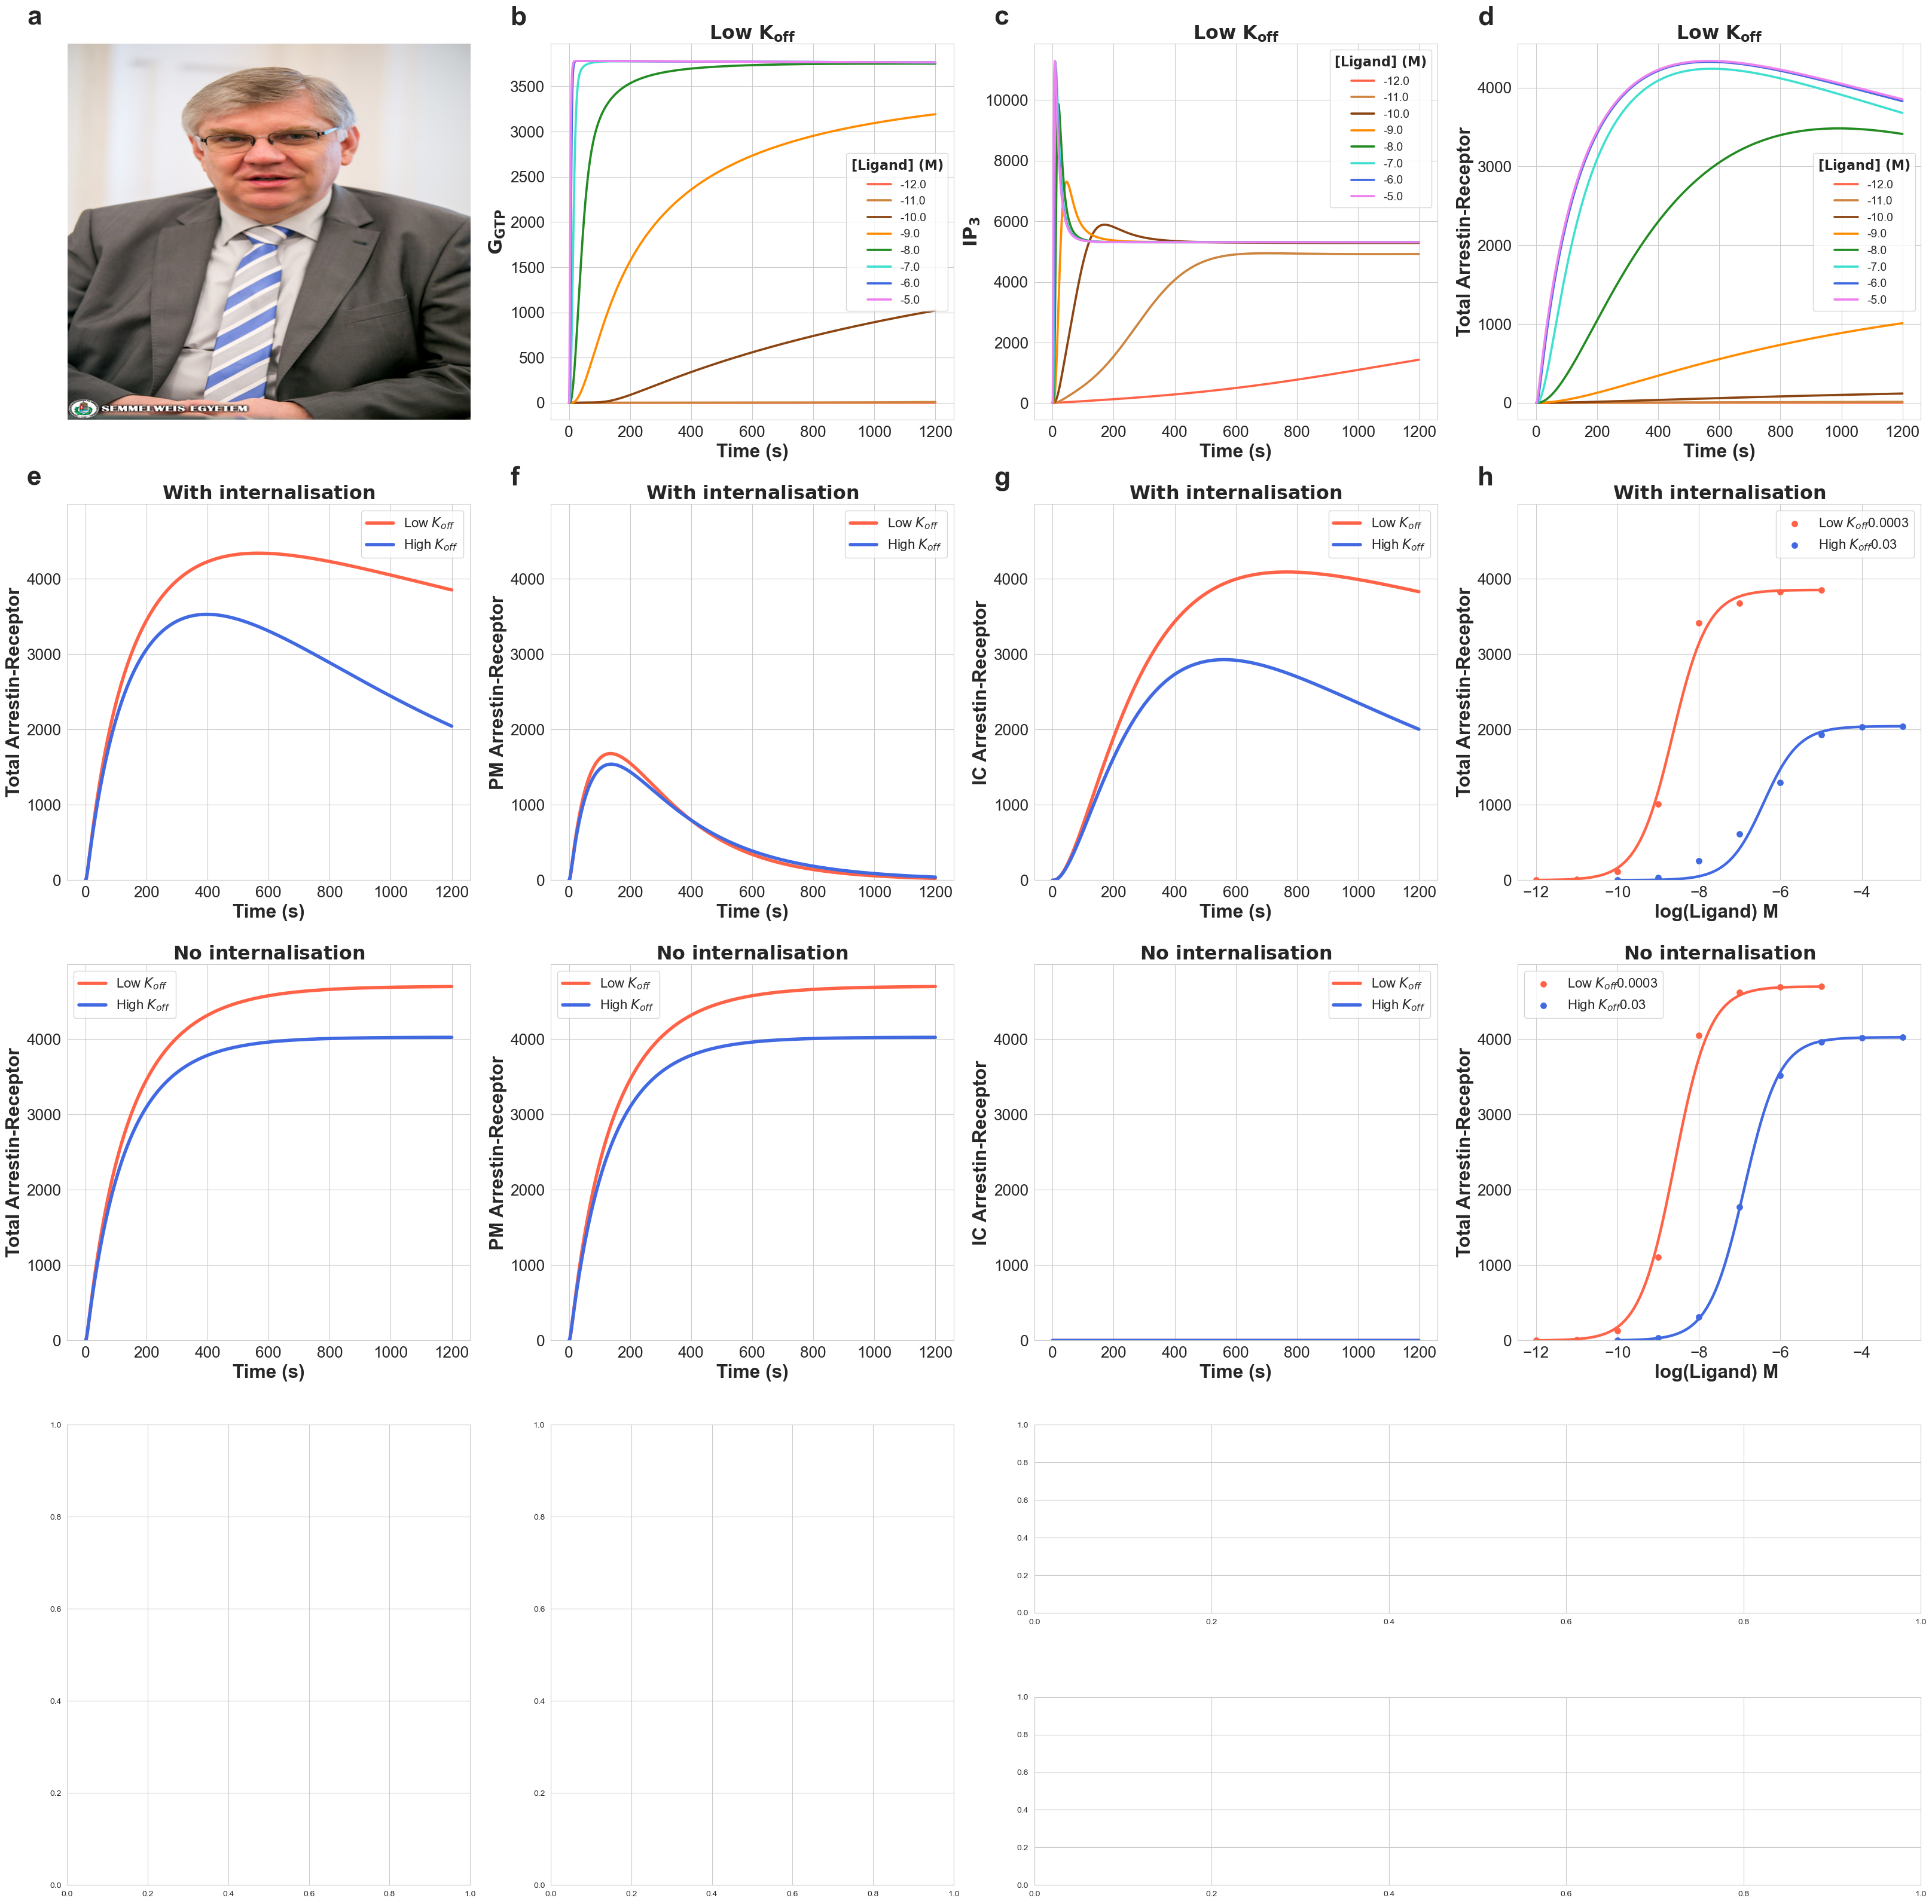

In [69]:
subplots_names=[['H_up'],['H_low']]
subplot_labels=['H']
molecules_to_plot=['Total Arrestin-Receptor']

time_to_response=1200

kon=0.3
koff_list=[low_koff,high_koff]
internalisation_status=['With_internalisation','No_internalisation']
process_name='Koff_Kon_all'
color_palette_dict=mcolors.CSS4_COLORS
color_names=['tomato','royalblue']#'peru','saddlebrown','darkorange','forestgreen','turquoise','royalblue','violet']

ligand_ccs=(10 ** np.arange(-6, 1.1, 1))

fig_width=40
fig_height=40

#fig,ax=plt.subplot_mosaic(subplot_layout,figsize=(fig_width,fig_height))

## FOntsize=fig_width*fig_height/title_fontsize_ratio
subplot_label_fontsize_nominator=50
subplot_title_fontsize_nominator=70
subplot_axis_label_fontsize_nominator=70
subplot_axis_tick_label_fontsize_nominator=85
subplot_legend_label_fontsize_nominator=100
subplot_legend_title_fontsize_nominator=100
#legend_title='$\mathbf{K_{off}}$'
legend_title=None
legend_handles=['Low $K_{off}$','High $K_{off}$']
plot_dot_size_nominator=35
linewidth_nominator=500


#### Experimental setup for the plot
exp_setup='receptor_arrestin_overexpression'

### Load the previosly ceated figur and axes object to plot to
with open(os.path.join(temp_dirname,'temporary_plot_A_G_fig_object.pkl'),'rb') as file:
    fig=pickle.load(file)
    plt.close()
with open(os.path.join(temp_dirname,'temporary_plot_A_G_axes_object.pkl'),'rb') as file:
    ax=pickle.load(file)

## Set common y-axis limit for all the plots in E-H
with open(os.path.join(temp_dirname,'arrestin_receptor_max_response.pkl'),'rb') as file:
    arrestin_receptor_max_response=pickle.load(file)
    ylim=arrestin_receptor_max_response*1.15

for molecule,colnum,subplot_label in zip(molecules_to_plot,range(np.asarray(subplots_names).shape[1]),subplot_labels):
    for intern_status,rownum in zip(internalisation_status,range(np.asarray(subplots_names).shape[0])):
        subplot_name=subplots_names[rownum][colnum]
        ax[subplot_name]=draw_DR_points_plus_fit_DR_curve(molecule,molecules_dict,kon,koff_list,intern_status,process_name,ligand_ccs,\
                                                        color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                                                        subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                                        subplot_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                                                        legend_title,subplot_legend_title_fontsize_nominator,legend_handles,time_to_response,ylim,\
                                                        subplot_label,subplot_label_fontsize_nominator,plot_dot_size_nominator,fig,exp_setup,\
                                                        linewidth_nominator)

## Save fig and axes object for later to add more subplots to it
with open(os.path.join(temp_dirname,'temporary_plot_A_H_fig_object.pkl'),'wb') as file:
    pickle.dump(fig,file)
with open(os.path.join(temp_dirname,'temporary_plot_A_H_axes_object.pkl'),'wb') as file:
    pickle.dump(ax,file)

# Show plots
plt.show()


## __I - J__ Add Emax-logEC50 plots (__I - J__)

In [87]:
def draw_emax_ec50_plot(molecule,molecules_dict,kon_list,koff_list,intern_status,process_name,ligand_ccs,\
                        color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                        subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                        subplot_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                        legend_title,subplot_legend_title_fontsize_nominator,legend_handles,time_to_response,ylim,\
                        subplot_label,subplot_label_fontsize_nominator,marker_size_nominator,marker_list,\
                        legend_marker_size_nominator,leg_y_coord,kon_legend_koff_legend_offset,
                        fig,exp_setup,leg_x_coord_i,leg_x_coord_j):
    
    ## Create directory path to load the data from
    dirname=os.path.join('../data/',exp_setup,intern_status,process_name,'')

    ## Define which subplot we want to plot into from the original subplot_mosaic object
    axis=ax[subplot_name]

    ## Get color palette 
    colors = [color_palette_dict.get(col) for col in color_names]

    plot_area=fig_width*fig_height

    ## Loop over the ligand concentrations, load the respective simulation data from the .csv file
    for kon,color in zip(kon_list,colors):
        Emax_list=[]
        logec50_list=[]
        for koff in koff_list:
            ## Adjust ligand concentrations to used Kon and Koff values +  convert it from uM/L to M/L (by subtracting 6 from hte logarithmic values of ligand ccs)
            ligands=np.log10(adjust_ligand_ccs(ligand_ccs,koff,kon)) - 6

            ## Create list to save the Dose-Response concentrations of the molecule at the given timepoint for given Koff-kon value pair
            DR_points=[]

            for ligand in ligands:
                mol_ccs_df=load_dataframe(dirname,process_name,ligand,kon,koff,molecules_dict,molecule)
                response_at_time=np.sum(mol_ccs_df.loc[time_to_response,:])
                DR_points.append(response_at_time)
            
            ## Function to fit DR curve on the DR-points extracted from the simulated data and return logEC50 for plotting the fitted DR curve
            def func(ligands, logec50):
                return max(DR_points) / (1 + 10 ** (logec50 - np.log10(ligands)))
            logec50, pcov = curve_fit(func, 10**ligands, DR_points,bounds=(-19,-1))

            ### Check the EC50 fits, as the receptor is quickly desinsitised and GTP values quickly drop due to the overexpression of arrrestin
            #if 'GTP' in molecule:
            #    fig, ax=plt.subplots(1,1)
            #    ax.scatter(ligands,DR_points)
            #    ax.axvline(x=logec50)
        
            ## Add EC50 and Emax to list
            logec50_list.append(logec50)
            Emax_list.append(DR_points[-1])

        
        ## Plot the Emax values on the y-axis and logec50 values on the x-axis
        for logec50,Emax,marker,koff in zip(logec50_list,Emax_list,marker_list,koff_list):
            axis.scatter(logec50, Emax,label=str(kon)+ ' - '+str(koff), color=color,s=plot_area/marker_size_nominator,marker=marker)
        
        
    #plot=axis.plot(mol_ccs_df.index.tolist(),np.sum(mol_ccs_df.loc[:,:],1),label=label,color=color)
    
    ## Customize legend, plot title, axis labels 
    
    kon_handles=[Patch(facecolor=color,label=str(kon)) for color,kon in zip(colors,kon_list)]
    #kon_handles=[Line2D([], [], color=color,label=str(koff),lw=plot_area/legend_marker_size_nominator) for color,koff in zip(colors,koff_list)]
    koff_handles=[Line2D([], [], color='b',marker=marker, linestyle='None',label=str(koff),markersize=plot_area/legend_marker_size_nominator) for koff,marker in zip(koff_list,marker_list)]
    legend_handles=kon_handles + koff_handles
    legend_labels=kon_list + koff_list

    #axis.legend(title=legend_title, labels=legend_labels,handles=legend_handles,title_fontsize=plot_area/subplot_legend_title_fontsize_nominator,\
    #            fontsize=plot_area/subplot_legend_label_fontsize_nominator,ncol=1)
    
    ## Set legend x-coordinate 
    if 'Arrestin' in molecule:
        leg_x_coord=leg_x_coord_i
    if 'GTP' in molecule:
        leg_x_coord=leg_x_coord_j
  
    ## Create legend for the Kon values (colour coding)
    color_legend = axis.legend(labels=kon_list,handles=kon_handles, title_fontsize=plot_area/subplot_legend_title_fontsize_nominator,\
                                fontsize=plot_area/subplot_legend_label_fontsize_nominator,title='$\mathbf{K_{on}}$', loc=(leg_x_coord,leg_y_coord))
    axis.add_artist(color_legend)

    ## Create legend for the Koff values (marker coding)
    marker_legend = axis.legend(labels=koff_list, handles=koff_handles, title_fontsize=plot_area/subplot_legend_title_fontsize_nominator,\
                                fontsize=plot_area/subplot_legend_label_fontsize_nominator,title='$\mathbf{K_{off}}$',loc=(leg_x_coord,leg_y_coord-kon_legend_koff_legend_offset))
    axis.add_artist(marker_legend)
    
    
    axis_label_fontsize=plot_area/subplot_axis_label_fontsize_nominator
    axis_tick_labelsize=plot_area/subplot_axis_tick_label_fontsize_nominator

    title_text=intern_status.replace('_','\ ')
    title="$\mathbf{E_{max}}$" +' - ' "$\mathbf{logEC_{50}}$"
    title_fontsize=plot_area/subplot_title_fontsize_nominator
    axis.set_title(title,fontsize=title_fontsize)

    axis.set_xlabel('$\mathbf{logEC_{50}}$',fontweight="bold",fontsize=axis_label_fontsize)

    ## If molecule is G_GTP, then do not change anything on that part of the string, as it is already TeX formulated
    if 'GTP' in molecule:
        y_axis_label=molecule + ' '+"$\mathbf{(E_{max})}$"
    
    ## TeX formulate Total Arrestin-Receptor string
    else:
        label_text=molecule.replace(' ','\ ')
        y_axis_label=r"$\mathbf{{title}}$".replace('title',label_text) +  ' '+ "$\mathbf{(E_{max})}$"

    axis.set_ylabel(y_axis_label,fontweight="bold",fontsize=axis_label_fontsize)
    axis.tick_params(axis='both', labelsize=axis_tick_labelsize)
    axis.set_ylim(0,ylim)

    axis.text(-0.1, 1.05,subplot_label.lower(),weight='bold',size=plot_area/subplot_label_fontsize_nominator,transform=axis.transAxes)
    
    #plt.tight_layout()  
    return(axis)

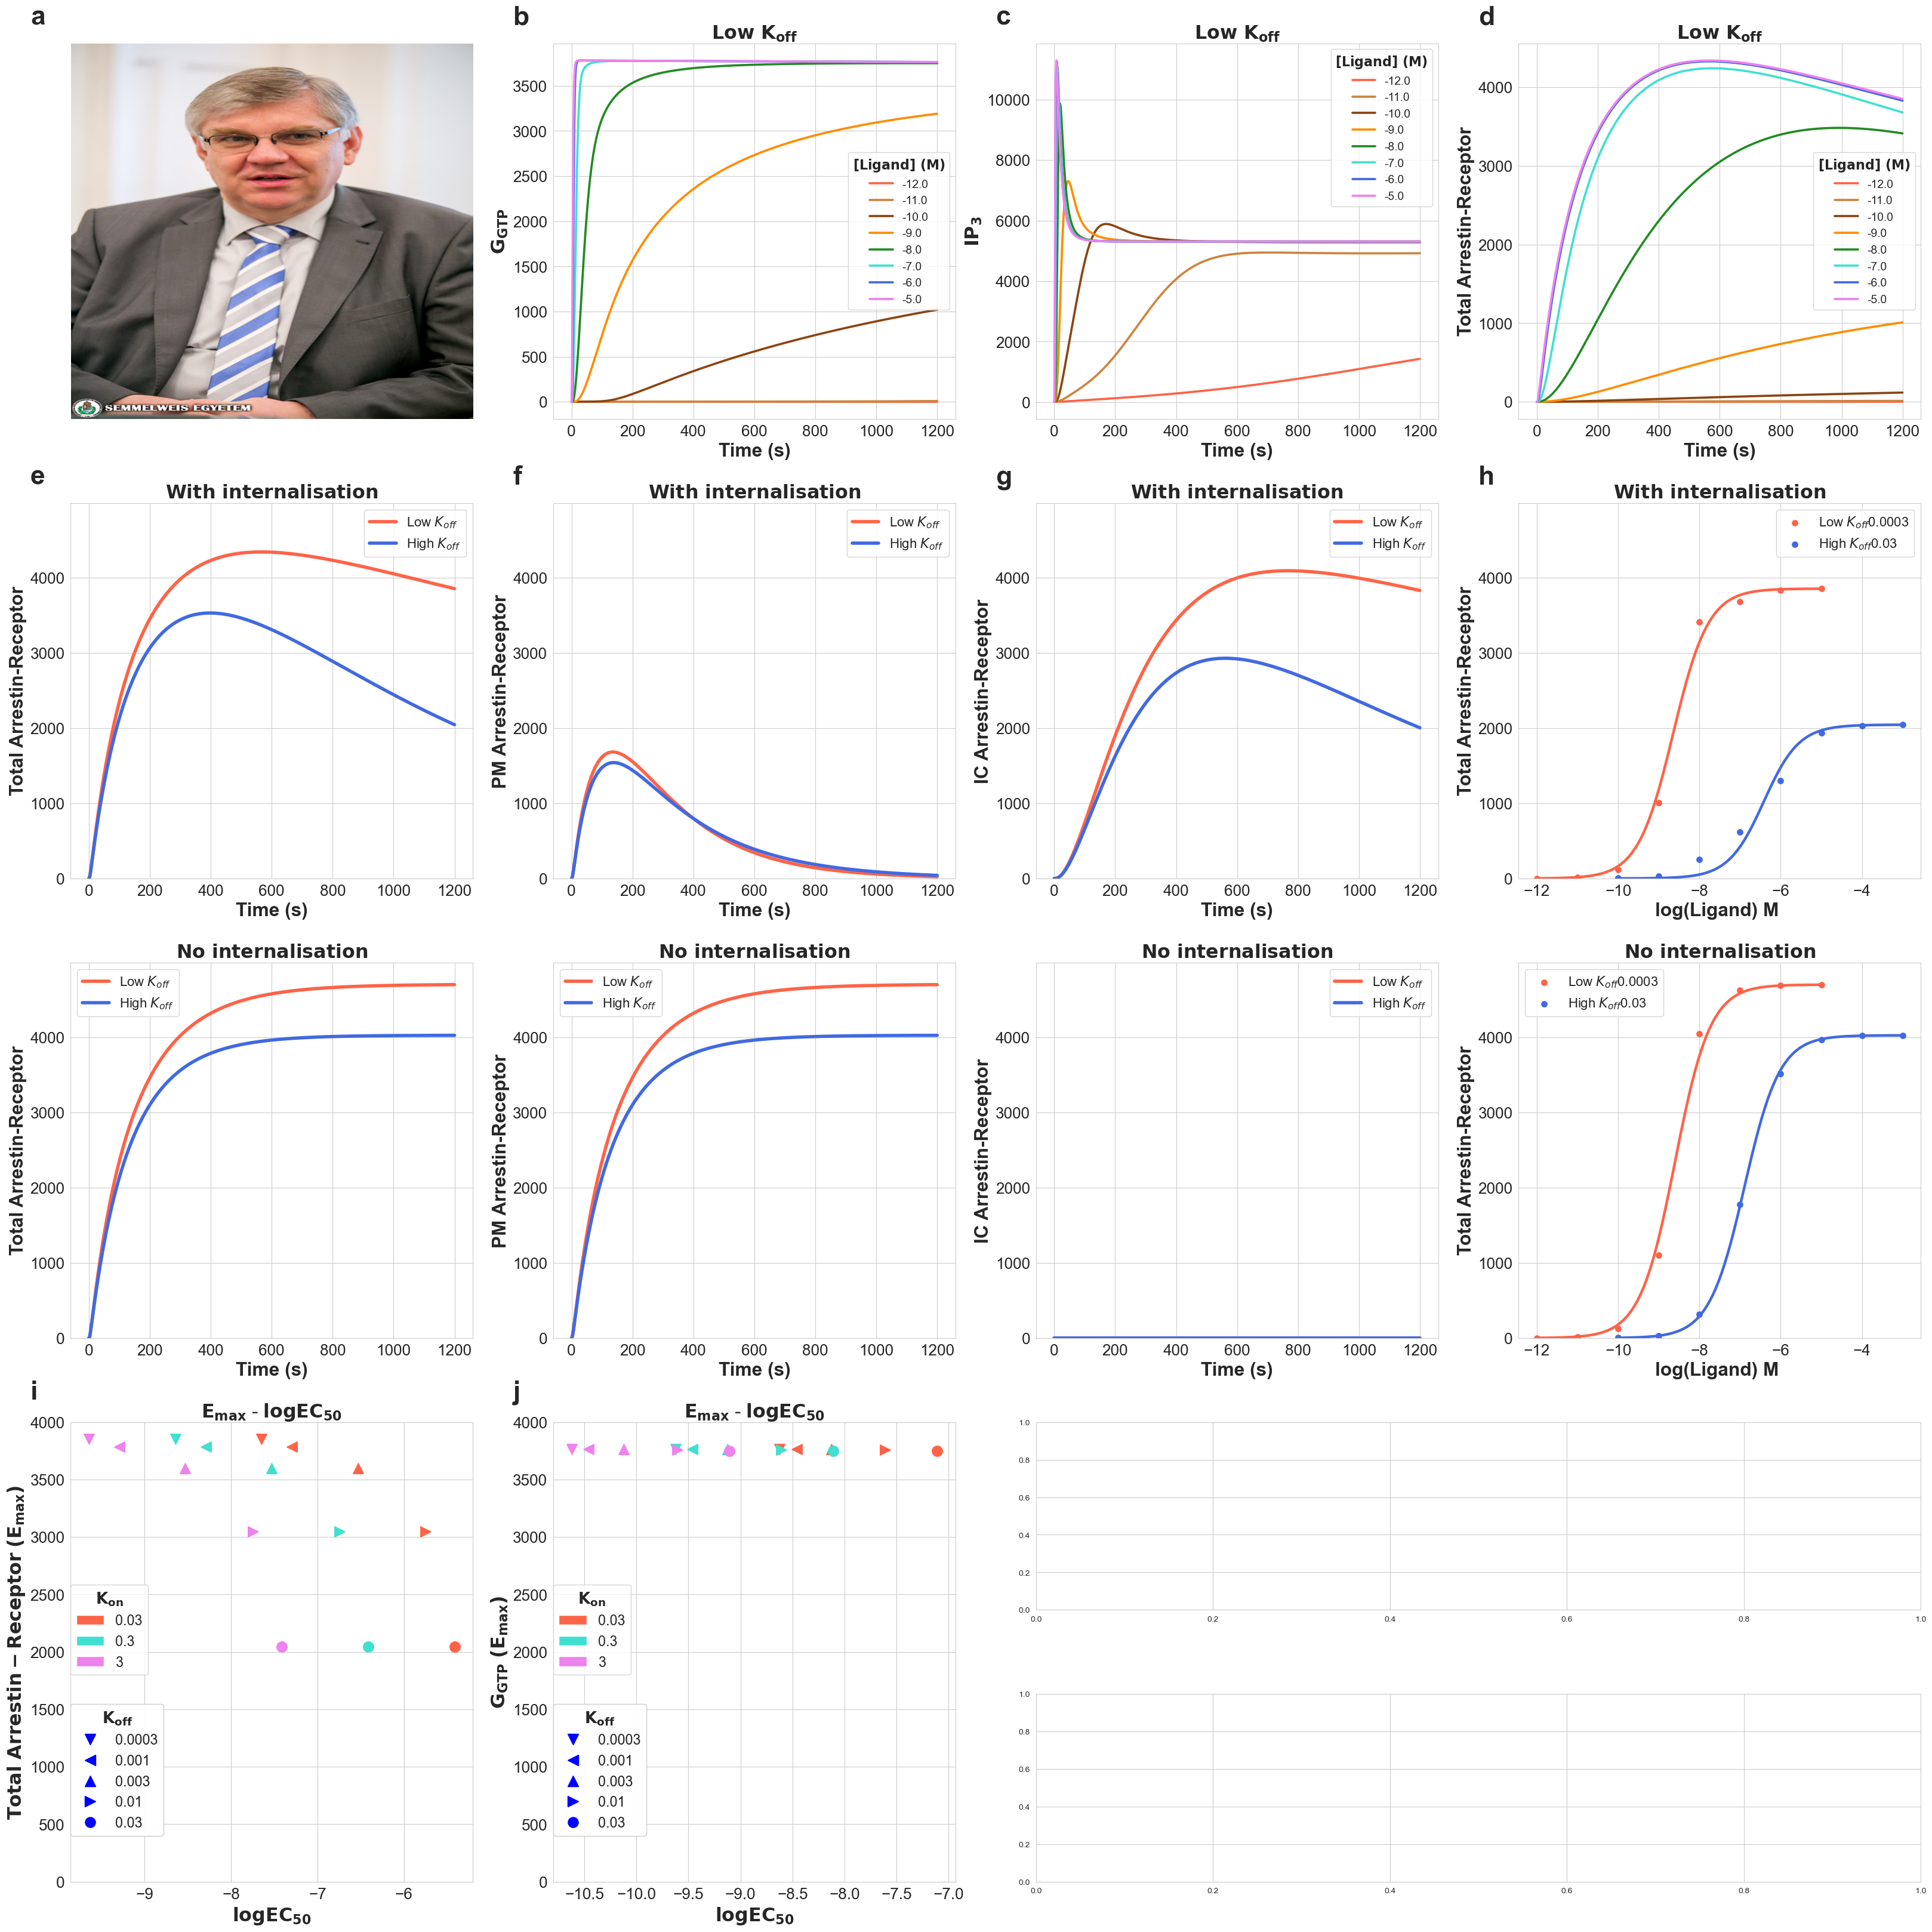

In [88]:
subplots_names=['I','J']
subplot_labels=['I','J']
molecules_to_plot=['Total Arrestin-Receptor','$\mathbf{G_{GTP}}$']

time_to_response=1200

kon_list=[0.03,0.3,3]
koff_list=[0.0003,0.001,0.003,0.01,0.03]#,0.1]
internalisation_status=['With_internalisation','No_internalisation']
intern_status='With_internalisation'
process_name='Koff_Kon_all'
color_palette_dict=mcolors.CSS4_COLORS
color_names=['tomato','turquoise','violet']#'peru','saddlebrown','darkorange','forestgreen','turquoise','royalblue','violet']

ligand_ccs=(10 ** np.arange(-6, 1.1, 1))

fig_width=40
fig_height=40


## FOntsize=fig_width*fig_height/title_fontsize_ratio
subplot_label_fontsize_nominator=50
subplot_title_fontsize_nominator=70
subplot_axis_label_fontsize_nominator=70
subplot_axis_tick_label_fontsize_nominator=85

subplot_legend_label_fontsize_nominator=95
subplot_legend_title_fontsize_nominator=85
legend_title='$\mathbf{K_{on}-K_{off}}$'

marker_size_nominator=10
legend_marker_size_nominator=130

marker_list=["v","<","^",">","o"]#,"s"]

## Set ylim and legend coordinates for I and J subplots
ylim=4000
leg_y_coord=0.45
leg_x_coord_i=0
leg_x_coord_j=0
## Set the offset-distance between the upper and lower legend
kon_legend_koff_legend_offset=0.35


#### Experimental setups for the plots I,J
experimental_setups=['receptor_arrestin_overexpression','receptor_gprotein_overexpression']

### Load the previosly ceated figur and axes object to plot to
with open(os.path.join(temp_dirname,'temporary_plot_A_H_fig_object.pkl'),'rb') as file:
    fig=pickle.load(file)
    plt.close()
with open(os.path.join(temp_dirname,'temporary_plot_A_H_axes_object.pkl'),'rb') as file:
    ax=pickle.load(file)

for molecule,subplot_name,subplot_label,exp_setup in zip(molecules_to_plot,subplots_names,subplot_labels,experimental_setups):
    ax[subplot_name]=draw_emax_ec50_plot(molecule,molecules_dict,kon_list,koff_list,intern_status,process_name,ligand_ccs,\
                                        color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                                        subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                        subplot_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                                        legend_title,subplot_legend_title_fontsize_nominator,legend_handles,time_to_response,ylim,\
                                        subplot_label,subplot_label_fontsize_nominator,marker_size_nominator,marker_list,\
                                        legend_marker_size_nominator,leg_y_coord,kon_legend_koff_legend_offset,\
                                        fig,exp_setup,leg_x_coord_i,leg_x_coord_j)

## Save fig and axes object for later to add more subplots to it
with open(os.path.join(temp_dirname,'temporary_plot_A_J_fig_object.pkl'),'wb') as file:
    pickle.dump(fig,file)
with open(os.path.join(temp_dirname,'temporary_plot_A_J_axes_object.pkl'),'wb') as file:
    pickle.dump(ax,file)

# Show plots
plt.show()


## __K__ Add Kinetic bias heatmap  (__K__)

In [95]:
def draw_kinetic_bias_heatmap(pathway1,pathway2,molecules_dict,kon,koff_list,intern_status,process_name,ligand_ccs,\
                        color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                        subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                        subplot_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                        legend_title,hm_cbar_legend_title_fontsize_nominator,legend_handles,timepoint_list,ylim,\
                        subplot_label,subplot_label_fontsize_nominator,hm_annot_fontsize_nominator,hm_cbar_axis_fontsize_nominator,\
                        high_koff,fig,pathway1_exp_setup,pathway2_exp_setup,hm_cbar_vmin,hm_cbar_vmax):
    
    
    ## Define which subplot we want to plot into from the original subplot_mosaic object
    axis=ax[subplot_name]

    ## Get color palette 
    colors = [color_palette_dict.get(col) for col in color_names]

    plot_area=fig_width*fig_height


    ## Create dictionary to collect results for each timepoint
    bias_factor_results_dict={}
    for time_to_response in timepoint_list:
        bias_factor_results_dict[time_to_response]={}
        for koff in koff_list:
            bias_factor_results_dict[time_to_response][koff]={}
            ## Collect Emax and logEC50 values for both reference and query ligand
            emax_dict={}
            ec50_dict={}
            for ligand_type,kon_ligand,koff_ligand in zip(['reference','ligand'],[0.3,kon],[0.0003,koff]):
                emax_dict[ligand_type]={}
                ec50_dict[ligand_type]={}

                ## Calculate Emax and logEC50 for both molecules per ligand type. 
                #  The bias factor is a comparison of the concentrations of the 2 molecules, 
                #  which indicates how biased the ligand is towards one of the compared pathways
                for pathway,expt_setup_for_pathway in zip([pathway1,pathway2],[pathway1_exp_setup,pathway2_exp_setup]):

                    ## Create directory path to load the data from
                    dirname=os.path.join('../data/',expt_setup_for_pathway,intern_status,process_name,'')        

                    ## Create list to save the Dose-Response concentrations of the molecule at the given timepoint for given Koff-kon value pair
                    DR_points=[]

                    ## Adjust ligand concentrations to used Kon and Koff values +  convert it from uM/L to M/L 
                    # (by subtracting 6 from hte logarithmic values of ligand ccs)
                    ligands=np.log10(adjust_ligand_ccs(ligand_ccs,koff_ligand,kon_ligand)) - 6

                    ## Loop over the ligand concentrations, load the respective simulation data from the .csv file
                    #  Extractn the molecule concantration at given timepoint -> collect it to DR_points
                    for ligand in ligands:
                        #print(ligand)
                        mol_ccs_df=load_dataframe(dirname,process_name,ligand,kon_ligand,koff_ligand,molecules_dict,pathway)
                        response_at_time=np.sum(mol_ccs_df.loc[time_to_response,:])
                        DR_points.append(response_at_time)     

                    ## Function to fit DR curve on the DR-points extracted from the simulated data and return logEC50 for calculating bias factor
                    def func(ligands, logec50):
                        return max(DR_points) / (1 + 10 ** (logec50 - np.log10(ligands)))
                    logec50, pcov = curve_fit(func, 10**ligands, DR_points,bounds=(-19,-1))

                    ## Add EC50 and Emax values to respective dictionaries
                    emax_dict[ligand_type][pathway]=DR_points[-1]
                    ec50_dict[ligand_type][pathway]=10**logec50

            ## Assign elements to variables in order make to calculation of Bias factor easy to interpret
            emax_p1_ref=emax_dict['reference'][pathway1]
            emax_p2_ref=emax_dict['reference'][pathway2]
            ec50_p1_ref=ec50_dict['reference'][pathway1]
            ec50_p2_ref=ec50_dict['reference'][pathway2]
            emax_p1_lig=emax_dict['ligand'][pathway1]
            emax_p2_lig=emax_dict['ligand'][pathway2]
            ec50_p1_lig=ec50_dict['ligand'][pathway1]
            ec50_p2_lig=ec50_dict['ligand'][pathway2]
            #print(time_to_response)
            #print(koff)
            #print(emax_p1_ref,emax_p2_ref,ec50_p1_ref,ec50_p2_ref,emax_p1_lig,emax_p2_lig,ec50_p1_lig,ec50_p2_lig)

            # Calculate Bias factor
            bias_factor=math.log10(((emax_p1_lig*ec50_p2_lig)/(ec50_p1_lig*emax_p2_lig)) * ((emax_p2_ref*ec50_p1_ref)/(ec50_p2_ref*emax_p1_ref)))
            
            ## Round bias factor to 0 if sufficiently enough to 0
            if abs(bias_factor)<0.000001:
                bias_factor=0
            bias_factor_results_dict[time_to_response][koff]=bias_factor

    ## Convert dictionary of result to DataFrame and plot a heatmap
    bias_factor_df=pd.DataFrame.from_dict(bias_factor_results_dict)
    bias_factor_df=bias_factor_df.set_axis(["$\mathbf{Low\ K_{off}}$","$\mathbf{High\ K_{off}}$"])
    
    
    ### PLot heatmap and customize legend
    hm=sns.heatmap(bias_factor_df,annot=True,cmap="YlGnBu_r", ax=axis,fmt='.3f',vmin=hm_cbar_vmin,vmax=hm_cbar_vmax,
                   cbar_kws={'label':legend_title,
                             'fraction':0.08},
                   annot_kws={'fontsize':plot_area/hm_annot_fontsize_nominator})   
    cbar_ax=hm.figure.axes[-1]
    cbar_ax.tick_params(labelsize=plot_area/hm_cbar_axis_fontsize_nominator)
    cbar_ax.yaxis.label.set_size(plot_area/hm_cbar_legend_title_fontsize_nominator)    
   
    ## Customize legend, plot title, axis labels        

    #axis.legend(title=legend_title,title_fontsize=plot_area/subplot_legend_title_fontsize_nominator,\
    #            fontsize=plot_area/subplot_legend_label_fontsize_nominator)
    
    axis_label_fontsize=plot_area/subplot_axis_label_fontsize_nominator
    axis_tick_labelsize=plot_area/subplot_axis_tick_label_fontsize_nominator

    ## If pathway1 is G_GTP, then do not change anything on that part of the string, as it is already TeX formulated and
    #  TeX formulate Total Arrestin-Receptor string
    if 'GTP' in pathway1:
        title_text1=pathway1
        title_text2=pathway2.replace(' ','\ ')
        title_text2="$\mathbf{{title}}$".replace('title',title_text2)
    elif 'GTP' in pathway2:
        title_text1=pathway1.replace(' ','\ ')
        title_text1="$\mathbf{{title}}$".replace('title',title_text1)
        title_text2=pathway2

    ## On upper plot show  what plot is about (bias factor Gtp vs arrestin-receptor) + internalisation status
    intern_status_tex=intern_status.replace('_','\ ')
    title="$\mathbf{Bias\ factor}$" +" (" +title_text1+ ' vs. ' +title_text2 +')'+'\n'+"$\mathbf{{title}}$".replace('title',intern_status_tex)
    
    ## On lower plot show only internalisation status in the title
    if intern_status=='No_internalisation':
        title="$\mathbf{{title}}$".replace('title',intern_status_tex)

    title_fontsize=plot_area/subplot_title_fontsize_nominator
    axis.set_title(title,fontsize=title_fontsize,fontweight='bold')

    axis.set_xlabel('Time (s)',fontweight="bold",fontsize=axis_label_fontsize)

    axis.tick_params(axis='both', labelsize=axis_tick_labelsize)
    #axis.set_ylim(0,ylim)

    ## If plot is in the upper row (=with internalistaion), then add plot label 
    if intern_status=='With_internalisation':
        axis.text(-0.1, 1.05,subplot_label.lower(),weight='bold',size=plot_area/subplot_label_fontsize_nominator,transform=axis.transAxes)
    
    plt.tight_layout()  
    return(hm)

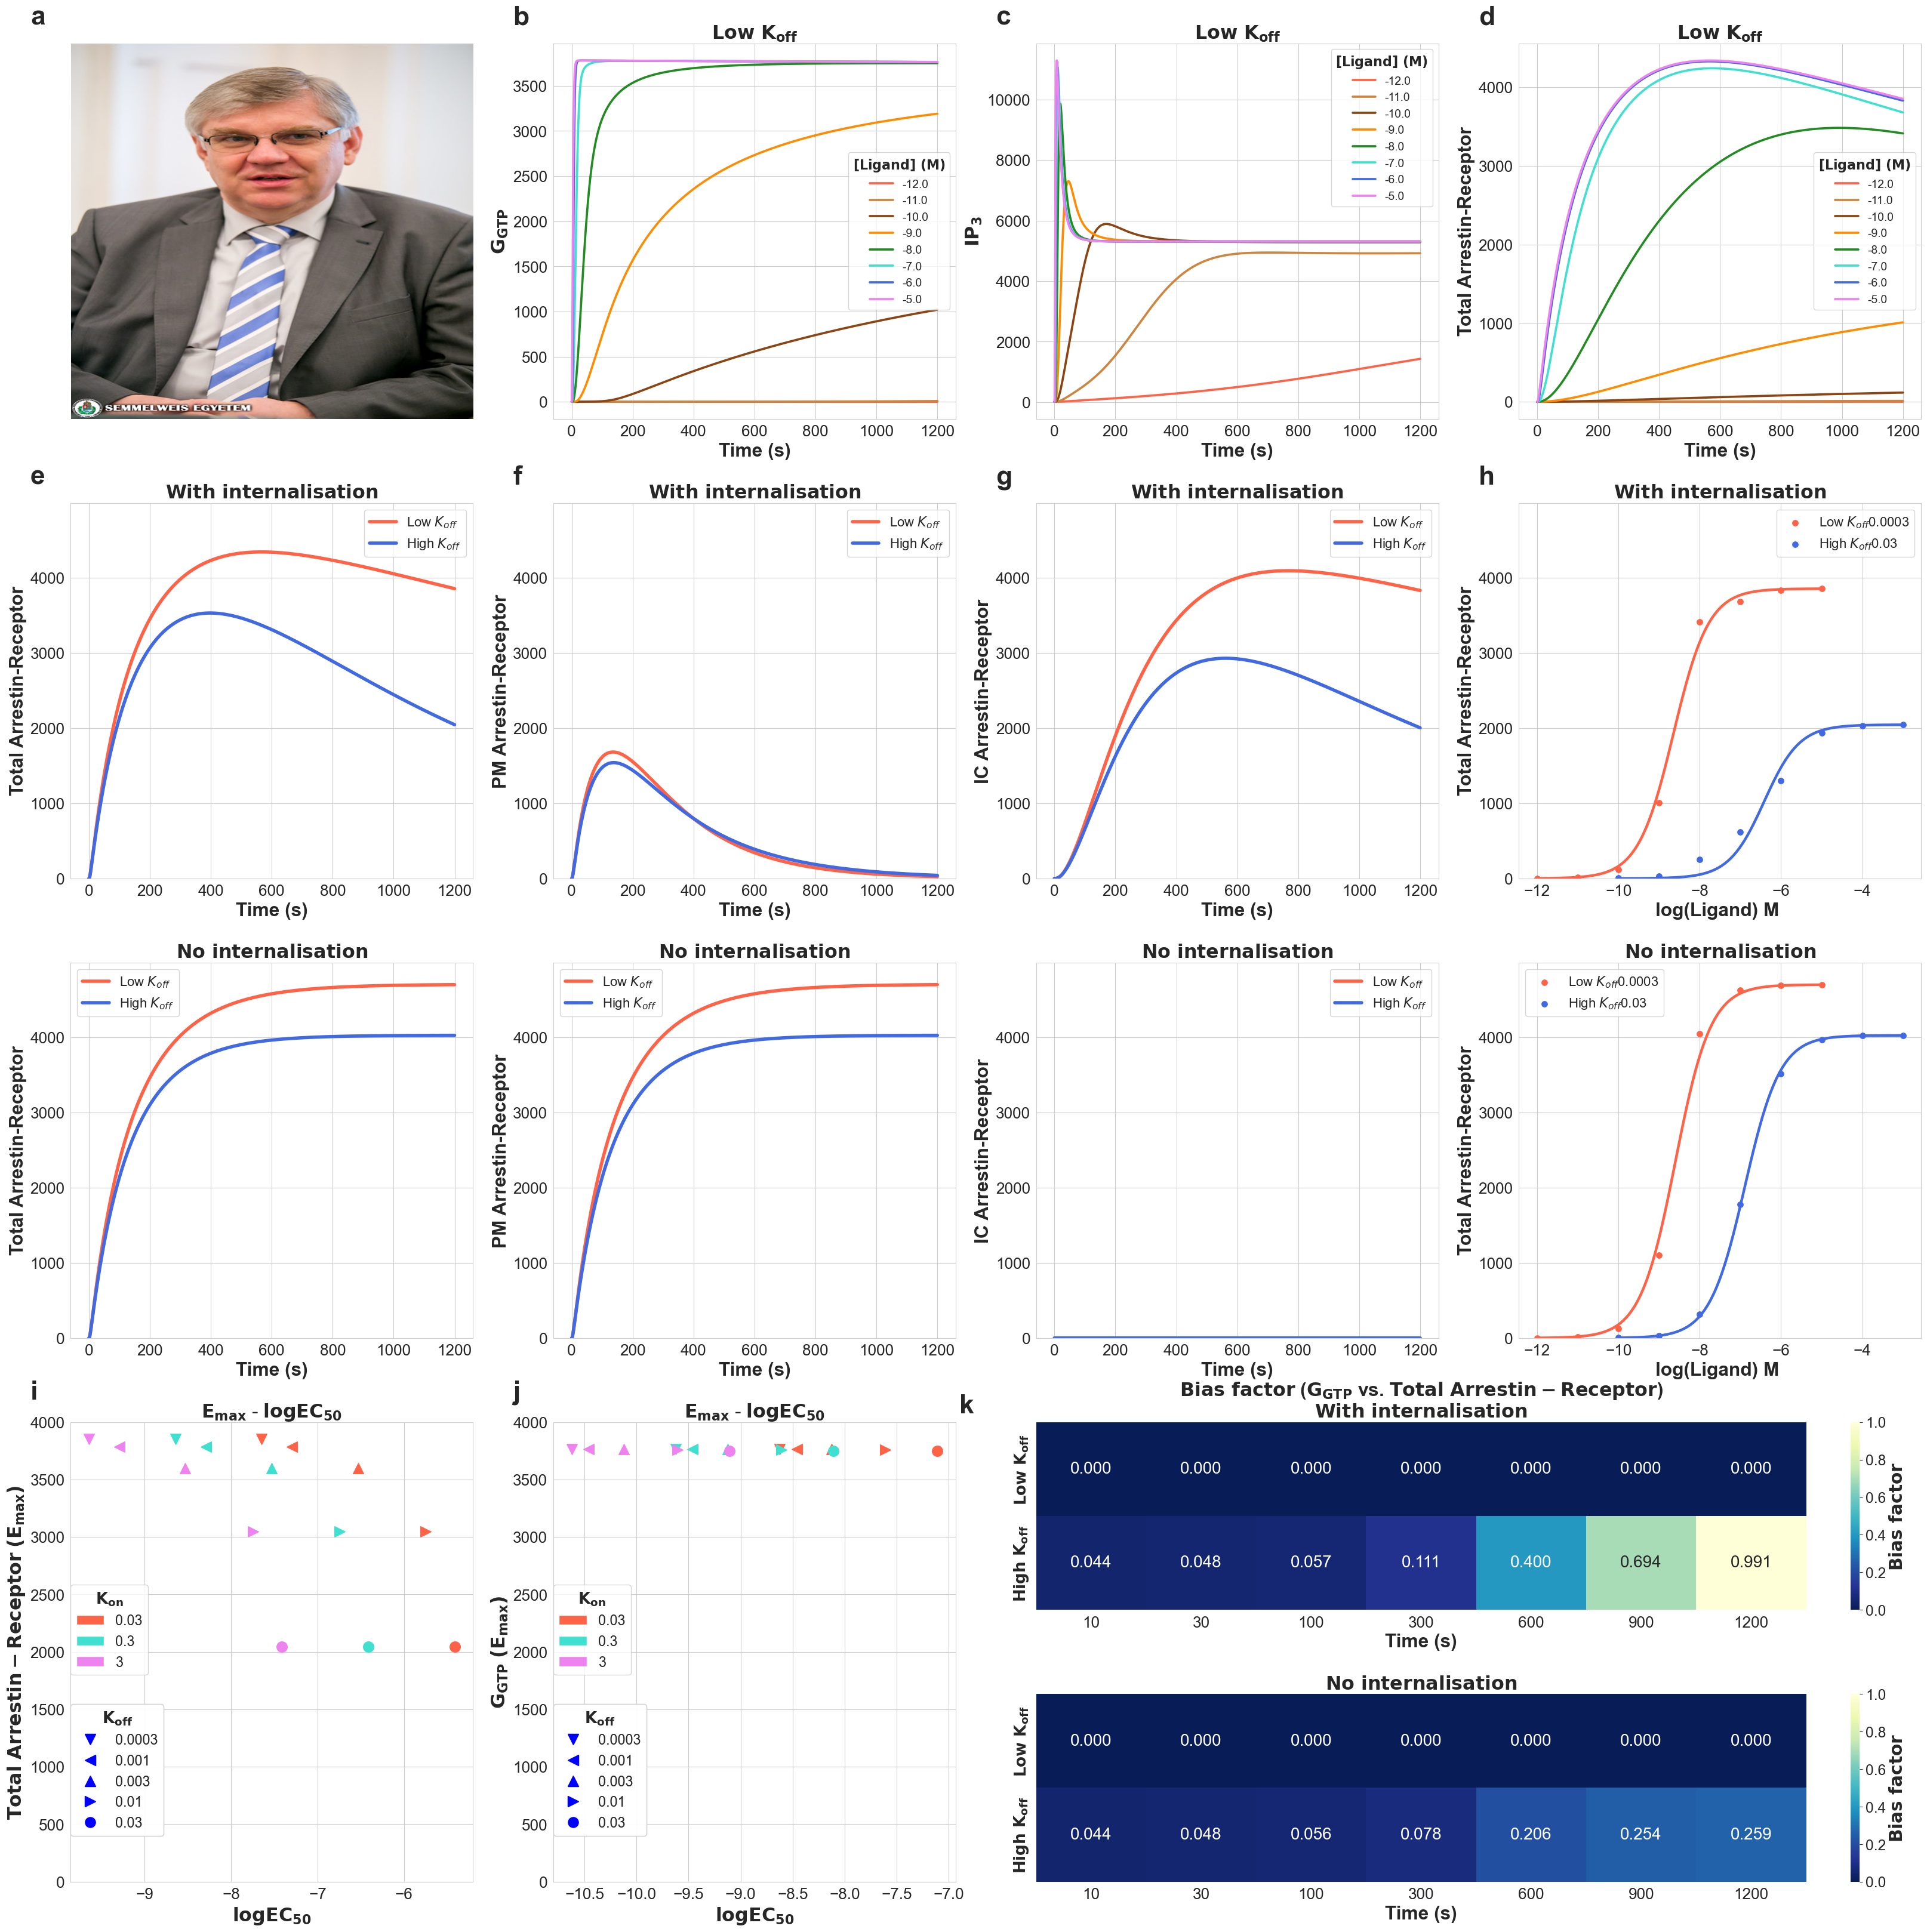

In [96]:
subplots_names=['K_up','K_low']
subplot_label='K'
molecules=['Total Arrestin-Receptor','$\mathbf{G_{GTP}}$']

pathway1='$\mathbf{G_{GTP}}$'
pathway2='Total Arrestin-Receptor'


time_to_response=1200

timepoint_list=[10,30,100,300,600,900,1200]
kon=0.3
koff_list=[low_koff,high_koff]
internalisation_status=['With_internalisation','No_internalisation']
process_name='Koff_Kon_all'
color_palette_dict=mcolors.CSS4_COLORS
color_names=['tomato','turquoise','violet']#'peru','saddlebrown','darkorange','forestgreen','turquoise','royalblue','violet']

ligand_ccs=(10 ** np.arange(-6, 1.1, 1))

fig_width=40
fig_height=40

## FOntsize=fig_width*fig_height/title_fontsize_ratio
subplot_label_fontsize_nominator=50
subplot_title_fontsize_nominator=70
subplot_axis_label_fontsize_nominator=70
subplot_axis_tick_label_fontsize_nominator=85
subplot_legend_label_fontsize_nominator=100

legend_title='$\mathbf{Bias\ factor}$'
#legend_handles=['Low $K_{off}$','High $K_{off}$']

## Heatmap colorbar features
hm_annot_fontsize_nominator=80
hm_cbar_axis_fontsize_nominator=90
hm_cbar_legend_title_fontsize_nominator=75
hm_cbar_vmin=0
hm_cbar_vmax=1

## Experimental setup of pathway 1 that is compared to pathway 2 
pathway1_exp_setup='receptor_gprotein_overexpression'

## In calculation of the bias factor, we always want to compare the results to the Total Receptor-Arrestin binding of 
# the receptor_arrestin_overexpression experimental setup
pathway2_exp_setup='receptor_arrestin_overexpression'

### Load the previosly ceated figur and axes object to plot to
with open(os.path.join(temp_dirname,'temporary_plot_A_J_fig_object.pkl'),'rb') as file:
    fig=pickle.load(file)
    plt.close()
with open(os.path.join(temp_dirname,'temporary_plot_A_J_axes_object.pkl'),'rb') as file:
    ax=pickle.load(file)

for subplot_name,intern_status in zip(subplots_names,internalisation_status):
    ax[subplot_name]=draw_kinetic_bias_heatmap(pathway1,pathway2,molecules_dict,kon,koff_list,intern_status,process_name,ligand_ccs,\
                                                color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                                                subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                                subplot_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                                                legend_title,hm_cbar_legend_title_fontsize_nominator,legend_handles,timepoint_list,ylim,\
                                                subplot_label,subplot_label_fontsize_nominator,hm_annot_fontsize_nominator,hm_cbar_axis_fontsize_nominator,
                                                high_koff,fig,pathway1_exp_setup,pathway2_exp_setup,hm_cbar_vmin,hm_cbar_vmax)

plt.savefig(os.path.join(temp_dirname,'temporary_plot_A_K.png'),dpi=300,bbox_inches='tight')

## Save fig and axes object for later to add more subplots to it
with open(os.path.join(temp_dirname,'temporary_plot_A_K_fig_object.pkl'),'wb') as file:
    pickle.dump(fig,file)
with open(os.path.join(temp_dirname,'temporary_plot_A_K_axes_object.pkl'),'wb') as file:
    pickle.dump(ax,file)
## Show plots
plt.show()

## __L__ Create and save boxplots with perturbations of different cellular processes:
- ### compare the 2 internalisation setups (yes vs. no) (__L__)

In [97]:
def create_perturbations_df(molecules,molecules_dict,kon,koff,internalisation_status,perturbed_processes,ligand_ccs,time_to_response,\
                            factor_list,exp_setup):

    
    ## Adjust ligand concentrations to used Kon and Koff values +  convert it from uM/L to M/L (by subtracting 6 from hte logarithmic values of ligand ccs)
    ligands=np.log10(adjust_ligand_ccs(ligand_ccs,koff,kon)) - 6
    
    ## Create dataframe to collect all of the results into
    perturbations_df_colnames=molecules + ['Factor','Perturbed process','Internalisation']
    perturbations_df=pd.DataFrame(columns=perturbations_df_colnames)

    for intern_status in internalisation_status:
        for process_name in perturbed_processes:
            ## Create directory path to load the data from
            dirname=os.path.join('../data/',exp_setup,intern_status,process_name,'')
            
            ## Create temporary dictionary collect the results of one perturbed process, which will get converted to DataFrame concatenated to perturbations_df
            process_results_dict={}
            
            for factor in factor_list:
                process_results_dict[factor]={}
                for molecule in molecules:
                                                    
                    ## Create list to save the Dose-Response concentrations of the molecule at the given timepoint for given Koff-kon value pair
                    DR_points=[]

                    ## Loop over the ligand concentrations, load the respective simulation data from the .csv file
                    for ligand in ligands:
                        mol_ccs_df=load_dataframe(dirname,process_name,ligand,kon,koff,molecules_dict,molecule,factor=factor)
                        response_at_time=np.sum(mol_ccs_df.loc[time_to_response,:])
                        DR_points.append(response_at_time)
                    
                    ## Append Emax value at given perturbation factor for given molecule, for given process and Koff/Kon
                    process_results_dict[factor][molecule]=DR_points[-1]
            
            ## Convert the results of perturbation of one process into a DataFrame
            process_df=pd.DataFrame.from_dict(process_results_dict)
            process_df=process_df.T
            process_df['Perturbed process']=process_name
            process_df['Internalisation']=intern_status
            process_df=process_df.rename_axis('Factor').reset_index()


            ## Concatenate the results from one process to the main result dataframe
            perturbations_df=pd.concat([perturbations_df,process_df],join="outer",ignore_index=True)

    return perturbations_df



def create_perturbations_boxplot(perturbations_df,molecules,internalisation_status,\
                                color_palette_dict,color_names,fig_width,fig_height,\
                                subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                subplot_y_axis_tick_label_fontsize_nominator,subplot_x_axis_tick_label_fontsize_nominator,\
                                subplot_legend_label_fontsize_nominator,\
                                legend_title,subplot_legend_title_fontsize_nominator,\
                                subplot_label,subplot_label_fontsize_nominator,\
                                palette,koff_status,plot_type):
    

    ## Get color palette 
    colors = [color_palette_dict.get(col) for col in color_names]
    plot_area=fig_width*fig_height

    ## Boxplots: x: perturbed process, y: Emax of molecule, Boxplot splitted by internalisation status 
    # Select relevant columns (drop molecules that are not necessary for analysis)
    colnames=['Factor','Perturbed process','Internalisation'] + molecules
    plot_df=perturbations_df.loc[:,colnames].melt(id_vars=["Factor",'Perturbed process','Internalisation'],var_name="Molecule",value_name="Values")
    plot_df['Factor']=plot_df['Factor'].astype(str)
    plot_df['Perturbed process']=plot_df['Perturbed process'].str.replace('_',' ')

    ## Create a boxplot with no facecolor and overlay a swarmplot
    g=sns.FacetGrid(data=plot_df, col='Internalisation',height=4, aspect=1.7,sharey=True)
    g.map_dataframe(sns.swarmplot,x="Perturbed process", y="Values",hue='Factor',palette=palette)
    if plot_type=='boxplot':
        g.map_dataframe(sns.boxplot,x="Perturbed process", y="Values",boxprops={'facecolor':'None'})
    if plot_type=='violinplot':
        g.map_dataframe(sns.violinplot,x="Perturbed process", y="Values",inner=None,color='white',saturation=0)


    ## Customize legend
    g.add_legend(title=legend_title,title_fontsize=plot_area/subplot_legend_title_fontsize_nominator,\
                fontsize=plot_area/subplot_legend_label_fontsize_nominator,loc='upper right',bbox_to_anchor=(1, 0.92))

    #g.fig.suptitle(figure_title,fontsize=plot_area/figure_title_fontsize_nominator)
    
    ## Add subplot label if Kooff==koff_low (upper row)
    if 'Low' in koff_status:
        g.axes.flat[0].text(-0.1, 1.05,subplot_label.lower(),weight='bold',\
                            size=plot_area/subplot_label_fontsize_nominator,transform=g.axes.flat[0].transAxes)
    
    ## Customize legend, plot title, axis labels 
    for g_ax, intern_status in zip(g.axes.flat,internalisation_status):
        for molecule in molecules:
            
            title_fontsize=plot_area/subplot_title_fontsize_nominator
            title_text=intern_status.replace('_','\ ')
            title_text="$\mathbf{{title}}$".replace('title',title_text) + ' ('+koff_status+')'
            g_ax.set_title(title_text,fontsize=title_fontsize)

            ## If molecule is G_GTP, then do not change anything on that part of the string, as it is already TeX formulated
            if 'GTP' in molecule:
                y_axis_label=molecule + "\n"+ "$\mathbf{(E_{max})}$"
            
            ## TeX formulate Total Arrestin-Receptor string
            else:
                label_text=molecule.replace(' ','\ ')
                y_axis_label=r"$\mathbf{{title}}$".replace('title',label_text) + " "+ "$\mathbf{(E_{max})}$"

            axis_label_fontsize=plot_area/subplot_axis_label_fontsize_nominator
            y_axis_tick_labelsize=plot_area/subplot_y_axis_tick_label_fontsize_nominator
            x_axis_tick_labelsize=plot_area/subplot_x_axis_tick_label_fontsize_nominator

            g_ax.set_ylabel(y_axis_label,fontweight="bold",fontsize=axis_label_fontsize)
            g_ax.tick_params(axis='y', labelsize=y_axis_tick_labelsize)
            g_ax.set_xlabel(None,fontweight="bold",fontsize=axis_label_fontsize)
            g_ax.set_xticklabels(g_ax.get_xticklabels(), rotation=90, weight='bold', size=x_axis_tick_labelsize)
            g_ax.set_ylim(0,)

    return(g)
    

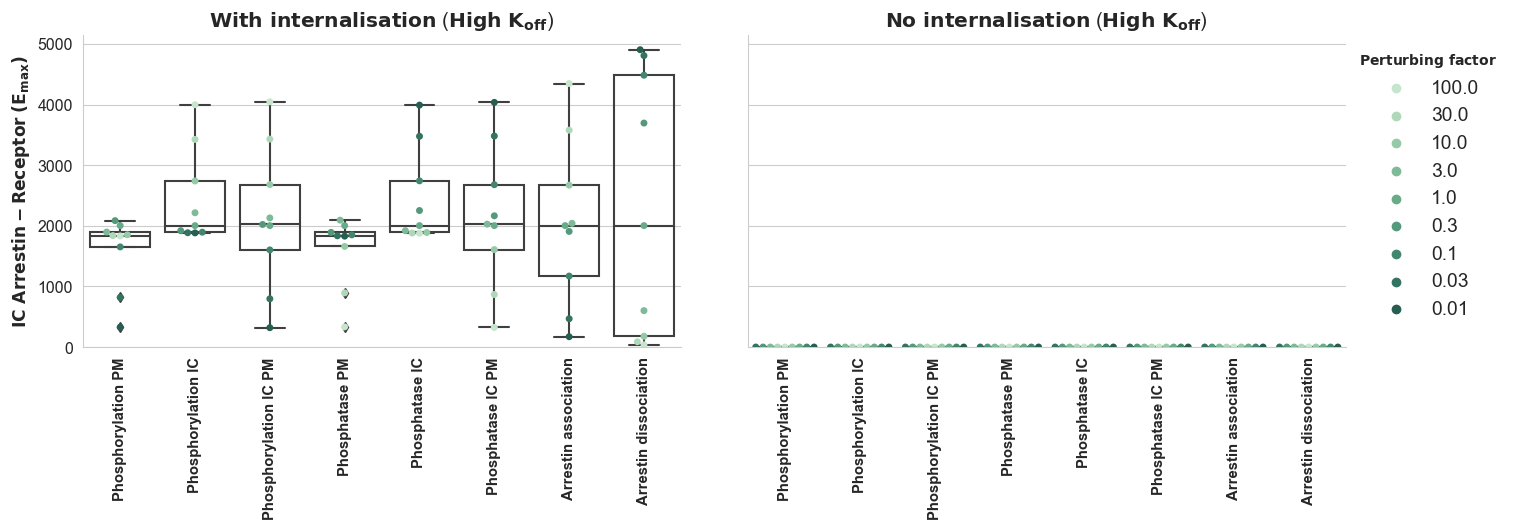

In [100]:
subplots_name='L'
subplot_label='L'
molecules=['Total Arrestin-Receptor']#,'PM Arrestin-Receptor','IC Arrestin-Receptor']

time_to_response=1200
factor_list=[100,30,10,3,1,0.3,0.1,0.03,0.01]

kon=0.3
koff_list=[high_koff]

perturbed_processes=['Phosphorylation_PM','Phosphorylation_IC','Phosphorylation_IC_PM',
                    'Phosphatase_PM','Phosphatase_IC','Phosphatase_IC_PM',
                    'Arrestin_association','Arrestin_dissociation']

process_name='Koff_Kon_all'
color_palette_dict=mcolors.CSS4_COLORS
color_names=['tomato','peru','saddlebrown','darkorange','forestgreen','turquoise','royalblue','violet','black']

ligand_ccs=(10 ** np.arange(-6, 1.1, 1))

fig_width=40
fig_height=40

## Color palette for the coloring of the factor point markers
palette = sns.color_palette("ch:2.5,-.2,dark=.3",n_colors=len(factor_list))

## FOntsize=fig_width*fig_height/title_fontsize_ratio
figure_title='$\mathbf{E_{max}\ values\ with\ perturbed\ cellular\ processes}$'
figure_title_fontsize_nominator=110

subplot_label_fontsize_nominator=95
subplot_title_fontsize_nominator=110

subplot_axis_label_fontsize_nominator=130

subplot_y_axis_tick_label_fontsize_nominator=140
subplot_x_axis_tick_label_fontsize_nominator=150

subplot_legend_label_fontsize_nominator=115
subplot_legend_title_fontsize_nominator=105
legend_title='$\mathbf{Perturbing\ factor}$'
#legend_handles=['Low $K_{off}$','High $K_{off}$']

hm_annot_fontsize_nominator=80

hm_cbar_axis_fontsize_nominator=90
hm_cbar_legend_title_fontsize_nominator=55

## PLot type of L and M plots: either boxplot or violinplot on top of swarmplot
plot_type='boxplot'
#plot_type='violinplot'

##### List containing the experimental setups to loop over and run model for
experimental_setups=['receptor_arrestin_overexpression']
molecules=['Total Arrestin-Receptor','PM Arrestin-Receptor','IC Arrestin-Receptor']

## Check if dataframes exist and if not, calculate a dataframe holding the results of the perturbations and save it, as it takes 2-3 minutes to compute
for exp_setup in experimental_setups:
    for koff in koff_list:
        filename=os.path.join(temp_dirname,'plot_L_perturbations_df_koff_'+str(koff)+'.csv')
        if os.path.isfile(filename)==True:
            continue
        if os.path.isfile(filename)==False:
            plot_L_perturbations_df=create_perturbations_df(molecules,molecules_dict,kon,koff,internalisation_status,perturbed_processes,ligand_ccs,\
                                                            time_to_response,factor_list,exp_setup)
            plot_L_perturbations_df.to_csv(filename)

### Experimental setups for the plot
experimental_setups=['receptor_arrestin_overexpression']
molecules=['IC Arrestin-Receptor']#,'PM Arrestin-Receptor','IC Arrestin-Receptor']
plot_type='boxplot'

for exp_setup in zip(experimental_setups):
    for koff,koff_status in zip(koff_list,['$\mathbf{High\ K_{off}}$']):
        
        filename=os.path.join(temp_dirname,'plot_L_perturbations_df_koff_'+str(koff)+'.csv')
        ## Read previously computed dataframe for plotting
        plot_L_perturbations_df=pd.read_csv(filename,index_col=0)
        
        g=create_perturbations_boxplot(plot_L_perturbations_df,molecules,internalisation_status,\
                                color_palette_dict,color_names,fig_width,fig_height,\
                                subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                subplot_y_axis_tick_label_fontsize_nominator,subplot_x_axis_tick_label_fontsize_nominator,\
                                subplot_legend_label_fontsize_nominator,\
                                legend_title,subplot_legend_title_fontsize_nominator,\
                                subplot_label,subplot_label_fontsize_nominator,\
                                palette,koff_status,plot_type)

        g.savefig(os.path.join(temp_dirname,'temporary_plot_L_koff_'+str(koff)+'_'+molecules[0]+'.png'),dpi=300)
        plt.show()



## __L2__ Create and save boxplots with perturbations of different cellular processes:
- ### compare the 2 timepoints setups (120 sec vs. 1200 sec) (__L2__)

In [123]:
def create_perturbations_df_L2(molecules,molecules_dict,kon,koff,internalisation_status,perturbed_processes,ligand_ccs,response_times,\
                            factor_list,exp_setup):

    
    ## Adjust ligand concentrations to used Kon and Koff values +  convert it from uM/L to M/L (by subtracting 6 from hte logarithmic values of ligand ccs)
    ligands=np.log10(adjust_ligand_ccs(ligand_ccs,koff,kon)) - 6
    
    ## Create dataframe to collect all of the results into
    perturbations_df_colnames=molecules + ['Factor','Perturbed process','Time to response']
    perturbations_df=pd.DataFrame(columns=perturbations_df_colnames)

    for time_to_response in response_times:
        for intern_status in internalisation_status:
            for process_name in perturbed_processes:
                ## Create directory path to load the data from
                dirname=os.path.join('../data/',exp_setup,intern_status,process_name,'')
                
                ## Create temporary dictionary collect the results of one perturbed process, which will get converted to DataFrame concatenated to perturbations_df
                process_results_dict={}
                
                for factor in factor_list:
                    process_results_dict[factor]={}
                    for molecule in molecules:
                                                        
                        ## Create list to save the Dose-Response concentrations of the molecule at the given timepoint for given Koff-kon value pair
                        DR_points=[]

                        ## Loop over the ligand concentrations, load the respective simulation data from the .csv file
                        for ligand in ligands:
                            mol_ccs_df=load_dataframe(dirname,process_name,ligand,kon,koff,molecules_dict,molecule,factor=factor)
                            response_at_time=np.sum(mol_ccs_df.loc[time_to_response,:])
                            DR_points.append(response_at_time)
                        
                        ## Append Emax value at given perturbation factor for given molecule, for given process and Koff/Kon
                        process_results_dict[factor][molecule]=DR_points[-1]
                
                ## Convert the results of perturbation of one process into a DataFrame
                process_df=pd.DataFrame.from_dict(process_results_dict)
                process_df=process_df.T
                process_df['Perturbed process']=process_name
                process_df['Time to response']=time_to_response
                process_df=process_df.rename_axis('Factor').reset_index()


                ## Concatenate the results from one process to the main result dataframe
                perturbations_df=pd.concat([perturbations_df,process_df],join="outer",ignore_index=True)
            
    return perturbations_df

    
def create_perturbations_boxplot_L2(perturbations_df,molecules,internalisation_status,\
                                color_palette_dict,color_names,fig_width,fig_height,\
                                subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                subplot_y_axis_tick_label_fontsize_nominator,subplot_x_axis_tick_label_fontsize_nominator,\
                                subplot_legend_label_fontsize_nominator,\
                                legend_title,subplot_legend_title_fontsize_nominator,\
                                subplot_label,subplot_label_fontsize_nominator,\
                                palette,koff_status,plot_type,time_to_response):
    

    ## Get color palette 
    colors = [color_palette_dict.get(col) for col in color_names]
    plot_area=fig_width*fig_height

    ## Boxplots: x: perturbed process, y: Emax of molecule, Boxplot splitted by internalisation status 
    # Select relevant columns (drop molecules that are not necessary for analysis)
    colnames=['Factor','Perturbed process','Time to response'] + molecules
    plot_df=perturbations_df.loc[perturbations_df['Time to response']==time_to_response,colnames].melt(id_vars=["Factor",'Perturbed process','Time to response'],var_name="Molecule",value_name="Values")
    plot_df['Factor']=plot_df['Factor'].astype(str)
    plot_df['Perturbed process']=plot_df['Perturbed process'].str.replace('_',' ')

    ## Create a boxplot with no facecolor and overlay a swarmplot
    g=sns.FacetGrid(data=plot_df, col='Molecule',height=4.2, aspect=1.8,sharey=False,gridspec_kws={"wspace":0.13})
    g.map_dataframe(sns.swarmplot,x="Perturbed process", y="Values",hue='Factor',palette=palette)
    if plot_type=='boxplot':
        g.map_dataframe(sns.boxplot,x="Perturbed process", y="Values",boxprops={'facecolor':'None'})
    if plot_type=='violinplot':
        g.map_dataframe(sns.violinplot,x="Perturbed process", y="Values",inner=None,color='white',saturation=0)


    ## Customize legend
    g.add_legend(title=legend_title,title_fontsize=plot_area/subplot_legend_title_fontsize_nominator,\
                fontsize=plot_area/subplot_legend_label_fontsize_nominator,loc='upper right',bbox_to_anchor=(1, 0.92))

    #g.fig.suptitle(figure_title,fontsize=plot_area/figure_title_fontsize_nominator)
    
    ## Add subplot label to the upper left corner of the subplot
    g.axes.flat[0].text(-0.1, 1.05,subplot_label.lower(),weight='bold',\
                            size=plot_area/subplot_label_fontsize_nominator,transform=g.axes.flat[0].transAxes)
    
    ## Customize legend, plot title, axis labels 
    for g_ax,molecule in zip(g.axes.flat,molecules):
        #for molecule in molecules:
            
            title_fontsize=plot_area/subplot_title_fontsize_nominator
            #title_text=intern_status.replace('_','\ ')
            title_text='Response\ at\ '+str(time_to_response)+ '\ seconds'
            title_text="$\mathbf{{title}}$".replace('title',title_text) + ' ('+koff_status+')'
            g_ax.set_title(title_text,fontsize=title_fontsize)

            ## If molecule is G_GTP, then do not change anything on that part of the string, as it is already TeX formulated
            if 'GTP' in molecule:
                y_axis_label=molecule + "\n"+ "$\mathbf{(E_{max})}$"
            
            ## TeX formulate Total Arrestin-Receptor string
            else:
                label_text=molecule.replace(' ','\ ')
                y_axis_label=r"$\mathbf{{title}}$".replace('title',label_text) + " "+ "$\mathbf{(E_{max})}$"

            axis_label_fontsize=plot_area/subplot_axis_label_fontsize_nominator
            y_axis_tick_labelsize=plot_area/subplot_y_axis_tick_label_fontsize_nominator
            x_axis_tick_labelsize=plot_area/subplot_x_axis_tick_label_fontsize_nominator

            g_ax.set_ylabel(y_axis_label,fontweight="bold",fontsize=axis_label_fontsize)
            g_ax.tick_params(axis='y', labelsize=y_axis_tick_labelsize)
            g_ax.set_xlabel(None,fontweight="bold",fontsize=axis_label_fontsize)
            g_ax.set_xticklabels(g_ax.get_xticklabels(), rotation=90, weight='bold', size=x_axis_tick_labelsize)
            g_ax.set_ylim(0,5000)

    return(g)

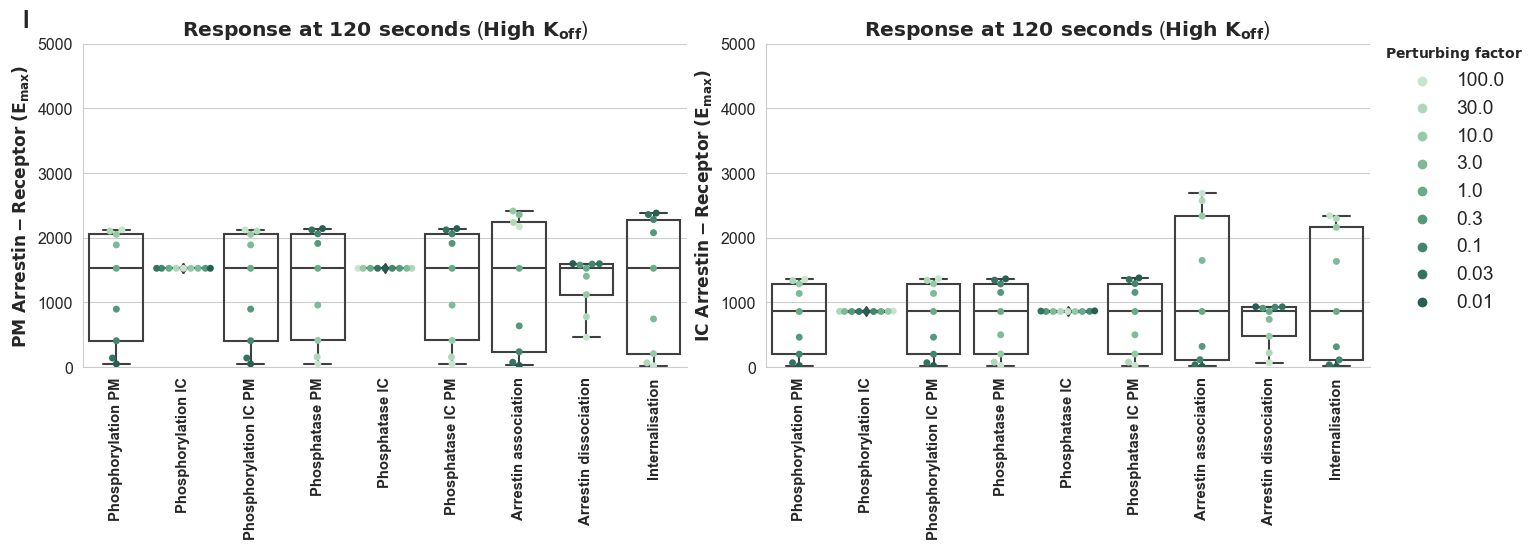

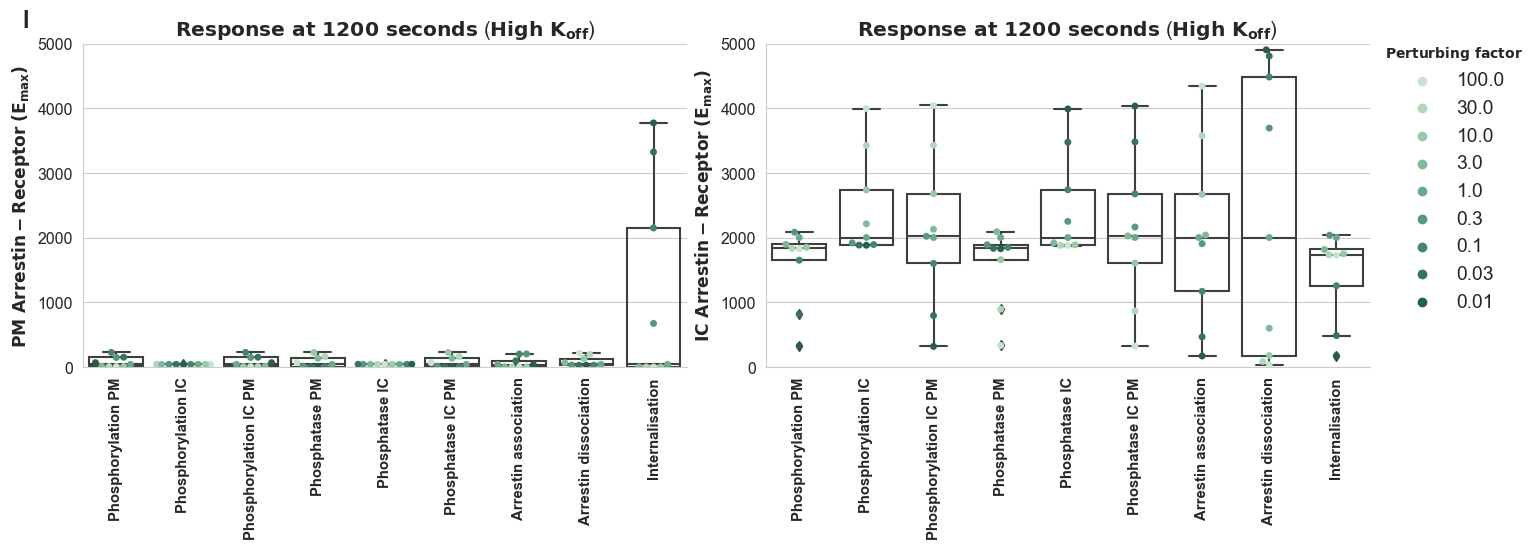

"\nsubplot_L2_120=Image.open(os.path.join(temp_dirname,'temporary_plot_L2_koff_'+str(koff)+'_time_to_response_120.png'))\nsubplot_L2_1200=Image.open(os.path.join(temp_dirname,'temporary_plot_L2_koff_'+str(koff)+'_time_to_response_1200.png'))\n\nsubplots_L2=[subplot_L2_120,subplot_L2_1200]\n\nresized_subplots=[subplots_L2[0]]\nfor im in subplots_L2[1:]:\n    scale_ratio=subplots_L2[0].size[0]/im.size[0]\n    resized_subplot=im.resize((subplots_L2[0].size[0],int(im.size[1]*scale_ratio)))\n    resized_subplots.append(resized_subplot)\n\nwidths, heights = zip(*(i.size for i in resized_subplots))\n\ntotal_width = max(widths)\nmax_height = sum(heights)\n\nnew_im = Image.new('RGB', (total_width, max_height+1000),(255,255,255))\n\n\ny_offsets=[im.size[1]+500 for im in resized_subplots]\ny_offsets[0] = 0\ny_offset=0\nfor im in resized_subplots:\n    print(y_offset)\n    new_im.paste(im, (0,y_offset))\n    y_offset += im.size[1]+85\n  \nnew_im.show()\nnew_im.save(os.path.join(temp_dirname,'tempo

In [124]:
subplots_name='L'
subplot_label='L'
molecules=['Total Arrestin-Receptor']#,'PM Arrestin-Receptor','IC Arrestin-Receptor']

time_to_response=1200
factor_list=[100,30,10,3,1,0.3,0.1,0.03,0.01]

kon=0.3
high_koff_l2=0.03
koff_list=[high_koff_l2]

perturbed_processes=['Phosphorylation_PM','Phosphorylation_IC','Phosphorylation_IC_PM',
                    'Phosphatase_PM','Phosphatase_IC','Phosphatase_IC_PM',
                    'Arrestin_association','Arrestin_dissociation','Internalisation']

process_name='Koff_Kon_all'
color_palette_dict=mcolors.CSS4_COLORS
color_names=['tomato','peru','saddlebrown','darkorange','forestgreen','turquoise','royalblue','violet','black']

ligand_ccs=(10 ** np.arange(-6, 1.1, 1))

fig_width=40
fig_height=40

## Color palette for the coloring of the factor point markers
palette = sns.color_palette("ch:2.5,-.2,dark=.3",n_colors=len(factor_list))

## FOntsize=fig_width*fig_height/title_fontsize_ratio
figure_title='$\mathbf{E_{max}\ values\ with\ perturbed\ cellular\ processes}$'
figure_title_fontsize_nominator=110

subplot_label_fontsize_nominator=95
subplot_title_fontsize_nominator=110

subplot_axis_label_fontsize_nominator=130

subplot_y_axis_tick_label_fontsize_nominator=140
subplot_x_axis_tick_label_fontsize_nominator=150

subplot_legend_label_fontsize_nominator=115
subplot_legend_title_fontsize_nominator=105
legend_title='$\mathbf{Perturbing\ factor}$'
#legend_handles=['Low $K_{off}$','High $K_{off}$']

hm_annot_fontsize_nominator=80

hm_cbar_axis_fontsize_nominator=90
hm_cbar_legend_title_fontsize_nominator=55

##### List containing the experimental setups to loop over and run model for
experimental_setups=['receptor_arrestin_overexpression']
molecules=['Total Arrestin-Receptor','PM Arrestin-Receptor','IC Arrestin-Receptor']
internalisation_status=['With_internalisation']
response_times=[120,1200]


## Check if dataframes exist and if not, calculate a dataframe holding the results of the perturbations and save it, as it takes 2-3 minutes to compute
for exp_setup in experimental_setups:
    for koff in koff_list:
        filename=os.path.join(temp_dirname,'plot_L2_perturbations_df_koff_'+str(koff)+'.csv')
        if os.path.isfile(filename)==True:
            continue
        if os.path.isfile(filename)==False:
            plot_L_perturbations_df=create_perturbations_df_L2(molecules,molecules_dict,kon,koff,internalisation_status,perturbed_processes,ligand_ccs,\
                                                            response_times,factor_list,exp_setup)
            plot_L_perturbations_df.to_csv(filename)

## Experimental setups, molecules, plt type for the plots
experimental_setups=['receptor_arrestin_overexpression']
molecules=['PM Arrestin-Receptor','IC Arrestin-Receptor']
plot_type='boxplot'
response_times=[120,1200]

for exp_setup in experimental_setups:
    for time_to_response in response_times:
        for koff,koff_status in zip(koff_list,['$\mathbf{High\ K_{off}}$']):
            
            filename=os.path.join(temp_dirname,'plot_L2_perturbations_df_koff_'+str(koff)+'.csv')
            ## Read previously computed dataframe for plotting
            plot_L_perturbations_df=pd.read_csv(filename,index_col=0)
            
            g=create_perturbations_boxplot_L2(plot_L_perturbations_df,molecules,internalisation_status,\
                                color_palette_dict,color_names,fig_width,fig_height,\
                                subplot_title_fontsize_nominator,subplot_axis_label_fontsize_nominator,\
                                subplot_y_axis_tick_label_fontsize_nominator,subplot_x_axis_tick_label_fontsize_nominator,\
                                subplot_legend_label_fontsize_nominator,\
                                legend_title,subplot_legend_title_fontsize_nominator,\
                                subplot_label,subplot_label_fontsize_nominator,\
                                palette,koff_status,plot_type,time_to_response)
            
            plot_name=os.path.join(temp_dirname,'temporary_plot_L2_koff_'+str(koff)+'_time_to_response_'+str(time_to_response)+'.png')
            g.savefig(plot_name,dpi=300)
            plt.show()


### IF MULTIPLE TIMEPOINTS ARE PLOTTED, YOU CAN CONCATENATE THEM INTO ONE .PNG FILE
### Concatenate the 2 plots created for the two timepoints 
#   For example: concatenate results from 120 seconds and 1200 seconds
'''
subplot_L2_120=Image.open(os.path.join(temp_dirname,'temporary_plot_L2_koff_'+str(koff)+'_time_to_response_120.png'))
subplot_L2_1200=Image.open(os.path.join(temp_dirname,'temporary_plot_L2_koff_'+str(koff)+'_time_to_response_1200.png'))

subplots_L2=[subplot_L2_120,subplot_L2_1200]

resized_subplots=[subplots_L2[0]]
for im in subplots_L2[1:]:
    scale_ratio=subplots_L2[0].size[0]/im.size[0]
    resized_subplot=im.resize((subplots_L2[0].size[0],int(im.size[1]*scale_ratio)))
    resized_subplots.append(resized_subplot)

widths, heights = zip(*(i.size for i in resized_subplots))

total_width = max(widths)
max_height = sum(heights)

new_im = Image.new('RGB', (total_width, max_height+1000),(255,255,255))


y_offsets=[im.size[1]+500 for im in resized_subplots]
y_offsets[0] = 0
y_offset=0
for im in resized_subplots:
    print(y_offset)
    new_im.paste(im, (0,y_offset))
    y_offset += im.size[1]+85
  
new_im.show()
new_im.save(os.path.join(temp_dirname,'temporary_plot_L2_koff_'+str(koff)+'_120_1200.png')
'''


## __M__ Create and save boxplots with perturbations of different cellular processes heatmap  (__M__)

In [108]:
def create_perturbations_df_koff_difference(molecules,molecules_dict,kon,koff_list,internalisation_status,perturbed_processes,ligand_ccs,time_to_response,\
                            factor_list,exp_setup):

    ## Create dataframe to collect the final results, both with internalisation and without internalisation
    intern_perturbations_df_colnames=molecules + ['Factor','Perturbed process','Internalisation']
    intern_perturbations_df=pd.DataFrame(columns=intern_perturbations_df_colnames)

    for intern_status in internalisation_status:
        
        ## Collect the perturbation results per Koff (high or low) to compute the ratio of the Receptor-Arrestin Emax values
        #  in the end
        perturbations_results_per_koff_dict={}
        for koff in koff_list:

            perturbations_results_per_koff_dict[koff]={}

            ## Adjust ligand concentrations to used Kon and Koff values +  convert it from uM/L to M/L (by subtracting 6 from hte logarithmic values of ligand ccs)
            ligands=np.log10(adjust_ligand_ccs(ligand_ccs,koff,kon)) - 6

            ## Create dataframe to collect perturbation results into for given koff, intern_status variables
            perturbations_df_colnames=molecules + ['Factor','Perturbed process','Internalisation']
            perturbations_df=pd.DataFrame(columns=perturbations_df_colnames)
            
            for process_name in perturbed_processes:
                ## Create directory path to load the data from
                dirname=os.path.join('../data/',exp_setup,intern_status,process_name,'')
                
                ## Create temporary dictionary collect the results of one perturbed process, which will get converted to DataFrame concatenated to perturbations_df
                process_results_dict={}
                
                for factor in factor_list:
                    process_results_dict[factor]={}
                    for molecule in molecules:
                                                        
                        ## Create list to save the Dose-Response concentrations of the molecule at the given timepoint for given Koff-kon value pair
                        DR_points=[]

                        ## Loop over the ligand concentrations, load the respective simulation data from the .csv file
                        for ligand in ligands:
                            mol_ccs_df=load_dataframe(dirname,process_name,ligand,kon,koff,molecules_dict,molecule,factor=factor)
                            response_at_time=np.sum(mol_ccs_df.loc[time_to_response,:])
                            DR_points.append(response_at_time)
                        
                        ## Append Emax value at given perturbation factor for given molecule, for given process and Koff/Kon
                        process_results_dict[factor][molecule]=DR_points[-1]
                
                ## Convert the results of perturbation of one process into a DataFrame
                process_df=pd.DataFrame.from_dict(process_results_dict)
                process_df=process_df.T
                process_df['Perturbed process']=process_name
                process_df['Internalisation']=intern_status
                process_df=process_df.rename_axis('Factor').reset_index()


                ## Concatenate the results from one process to the main result dataframe
                perturbations_df=pd.concat([perturbations_df,process_df],join="outer",ignore_index=True)
            
            ## Save perturbation effects of both low and high Koff value
            perturbations_results_per_koff_dict[koff]=perturbations_df
        
        ## To have a better overview, assign the collected results to variables and calculate the difference 
        #  between High/Low Koff Arrestin-Receptor concentration results
        high_koff_df=perturbations_results_per_koff_dict[koff_list[-1]]
        low_koff_df=perturbations_results_per_koff_dict[koff_list[0]]
        
        perturbations_df_high_per_low_koff_diff=low_koff_df.copy()
        perturbations_df_high_per_low_koff_diff[molecule]=low_koff_df[molecule]-high_koff_df[molecule]

        ## Concatenate the Arrestin-Receptor ratio dataframes into a finel dataframe, where 'Internalisation' column indicates
        # internalisation status
        intern_perturbations_df=pd.concat([intern_perturbations_df,perturbations_df_high_per_low_koff_diff],join="outer",ignore_index=True)    

    return intern_perturbations_df



def create_perturbations_boxplot_koff_ratio(perturbations_df,molecules,molecules_dict,kon,koff_list,intern_status,perturbed_processes,ligand_ccs,\
                                color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                                subplot_title_fontsize_nominator,subplot_x_axis_label_fontsize_nominator,subplot_y_axis_label_fontsize_nominator,\
                                subplot_y_axis_tick_label_fontsize_nominator,subplot_x_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                                legend_title,subplot_legend_title_fontsize_nominator,legend_handles,time_to_response,ylim,\
                                subplot_label,subplot_label_fontsize_nominator,marker_size_nominator,factor_list,figure_title,\
                                figure_title_fontsize_nominator,palette,plot_type):
    

    ## Get color palette 
    colors = [color_palette_dict.get(col) for col in color_names]
    plot_area=fig_width*fig_height

    ## Create dataframe for plotting
    plot_df=perturbations_df.melt(id_vars=["Factor",'Perturbed process','Internalisation'],var_name="Molecule",value_name="Values")
    plot_df['Factor']=plot_df['Factor'].astype(str)
    plot_df['Perturbed process']=plot_df['Perturbed process'].str.replace('_',' ')


    ## Create a boxplot with no facecolor and overlay a swarmplot
    g=sns.FacetGrid(data=plot_df, col='Internalisation',height=4, aspect=1.7,sharey=True)
    g.map_dataframe(sns.swarmplot,x="Perturbed process", y="Values",hue='Factor',palette=palette)
    if plot_type=='boxplot':
        g.map_dataframe(sns.boxplot,x="Perturbed process", y="Values",boxprops={'facecolor':'None'})
    if plot_type=='violinplot':
        g.map_dataframe(sns.violinplot,x="Perturbed process", y="Values",inner=None,color='white',saturation=0)

    ## Customize legend
    g.add_legend(title=legend_title,title_fontsize=plot_area/subplot_legend_title_fontsize_nominator,\
                fontsize=plot_area/subplot_legend_label_fontsize_nominator,loc='upper right',bbox_to_anchor=(1, 0.92))

    #g.fig.suptitle(figure_title,fontsize=plot_area/figure_title_fontsize_nominator)
    
    g.axes.flat[0].text(-0.1, 1.05,subplot_label.lower(),weight='bold',\
                        size=plot_area/subplot_label_fontsize_nominator,transform=g.axes.flat[0].transAxes)
    
    ## Customize legend, plot title, axis labels 
    for g_ax, intern_status in zip(g.axes.flat,intern_status):
        for molecule in molecules:
        
            title_fontsize=plot_area/subplot_title_fontsize_nominator
            title_text=intern_status.replace('_','\ ')

            title_text="$\mathbf{{title}}$".replace('title',title_text)
            g_ax.set_title(title_text,fontsize=title_fontsize)

            ## If molecule is G_GTP, then do not change anything on that part of the string, as it is already TeX formulated
            if 'GTP' in molecule:
                y_axis_label=molecule + "\n"+ "$\mathbf{(E_{max})}$"
            
            ## TeX formulate Total Arrestin-Receptor string
            else:
                label_text=molecule.replace(' ','\ ')
                y_axis_label=r"$\mathbf{High/Low\ K_{off}}$" +'\n' +"$\mathbf{{title}}$".replace('title',label_text) + " "+ "$\mathbf{ratio}$"
                y_axis_label=r"$\mathbf{\Delta}$" + " "+"$\mathbf{{title}}$".replace('title',label_text)+'\n'+ "$\mathbf{Low - High\ K_{off}}$"

            x_axis_label_fontsize=plot_area/subplot_x_axis_label_fontsize_nominator
            y_axis_label_fontsize=plot_area/subplot_y_axis_label_fontsize_nominator
            y_axis_tick_labelsize=plot_area/subplot_y_axis_tick_label_fontsize_nominator
            x_axis_tick_labelsize=plot_area/subplot_x_axis_tick_label_fontsize_nominator

            g_ax.set_ylabel(y_axis_label,fontweight="bold",fontsize=y_axis_label_fontsize)
            g_ax.tick_params(axis='y', labelsize=y_axis_tick_labelsize)
            g_ax.set_xlabel(None,fontweight="bold",fontsize=x_axis_label_fontsize)
            g_ax.set_xticklabels(g_ax.get_xticklabels(), rotation=90, weight='bold', size=x_axis_tick_labelsize)
            #g_ax.set_ylim(0,)

    return(g)    


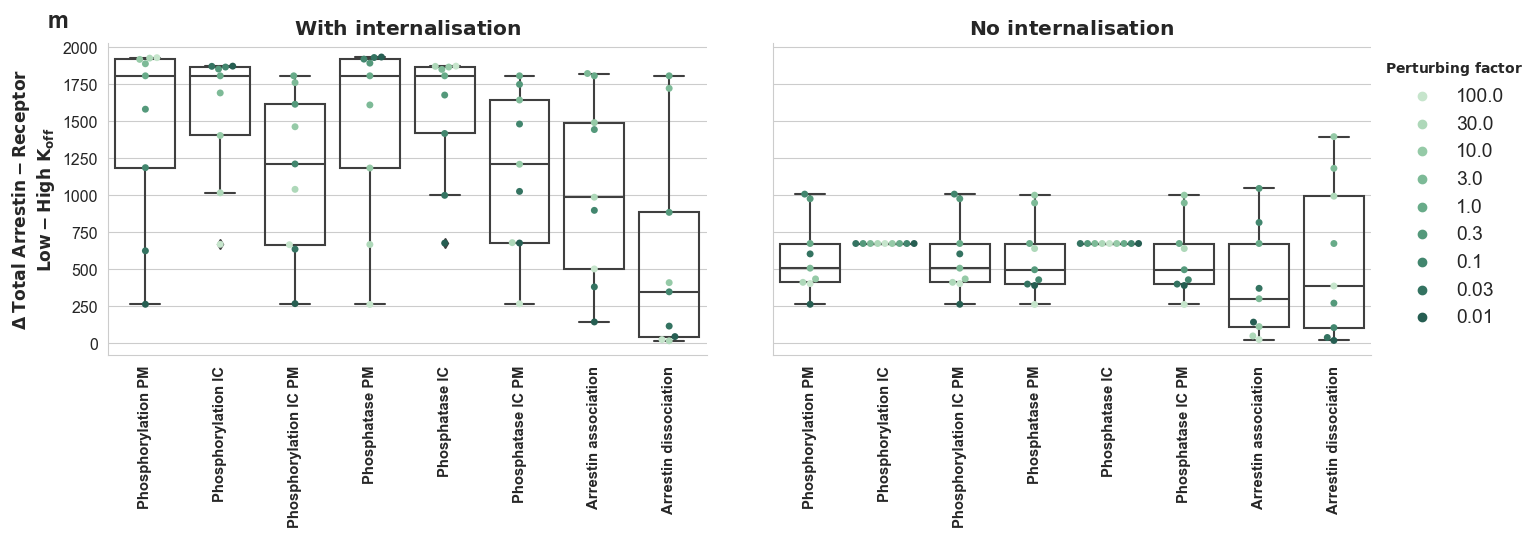

In [111]:
subplots_names=['M']
subplot_labels=['M']
molecules=['Total Arrestin-Receptor']

time_to_response=1200
factor_list=[100,30,10,3,1,0.3,0.1,0.03,0.01]

kon=0.3
## Always initialise Koff list with ascending values!
koff_list=[low_koff,high_koff]

internalisation_status=['With_internalisation','No_internalisation']
perturbed_processes=['Phosphorylation_PM','Phosphorylation_IC','Phosphorylation_IC_PM',
                    'Phosphatase_PM','Phosphatase_IC','Phosphatase_IC_PM',
                    'Arrestin_association','Arrestin_dissociation']

process_name='Koff_Kon_all'
color_palette_dict=mcolors.CSS4_COLORS
color_names=['tomato','peru','saddlebrown','darkorange','forestgreen','turquoise','royalblue','violet','black']

ligand_ccs=(10 ** np.arange(-6, 1.1, 1))

fig_width=40
fig_height=40

## Color palette for the coloring of the factor point markers
palette = sns.color_palette("ch:2.5,-.2,dark=.3",n_colors=len(factor_list))

## FOntsize=fig_width*fig_height/title_fontsize_ratio
figure_title='$\mathbf{E_{max}\ values\ with\ perturbed\ cellular\ processes}$'
figure_title_fontsize_nominator=110

subplot_label_fontsize_nominator=95
subplot_title_fontsize_nominator=110

subplot_x_axis_label_fontsize_nominator=130
subplot_y_axis_label_fontsize_nominator=130

subplot_y_axis_tick_label_fontsize_nominator=140
subplot_x_axis_tick_label_fontsize_nominator=150

subplot_legend_label_fontsize_nominator=115
subplot_legend_title_fontsize_nominator=105
legend_title='$\mathbf{Perturbing\ factor}$'
#legend_handles=['Low $K_{off}$','High $K_{off}$']

hm_annot_fontsize_nominator=80

hm_cbar_axis_fontsize_nominator=90
hm_cbar_legend_title_fontsize_nominator=55


## PLot type of L and M plots: either boxplot or violinplot
plot_type='boxplot'
#plot_type='violinplot'

##### List containing the experimental setups to loop over and run model for
molecules=['Total Arrestin-Receptor']
experimental_setups=['receptor_arrestin_overexpression']

for exp_setup in experimental_setups:
    ## Check if dataframes exist and if not, calculate a dataframe holding the results of the perturbations and save it, as it takes 2-3 minutes to compute
    for koff in koff_list:
        filename=os.path.join(temp_dirname,'plot_M_perturbations_df_high_koff_'+str(high_koff)+'.csv')
        if os.path.isfile(filename)==True:
            continue
        if os.path.isfile(filename)==False:
            plot_M_perturbations_df=create_perturbations_df_koff_difference(molecules,molecules_dict,kon,koff_list,internalisation_status,\
                                                                    perturbed_processes,ligand_ccs,time_to_response,factor_list,exp_setup)
            plot_M_perturbations_df.to_csv(filename)

### Plot the results of the perturbations dataset
experimental_setups=['receptor_arrestin_overexpression']
for exp_setup in experimental_setups:
    filename=os.path.join(temp_dirname,'plot_M_perturbations_df_high_koff_'+str(high_koff)+'.csv')

    ## Read previously computed dataframe for plotting
    plot_M_perturbations_df=pd.read_csv(filename,index_col=0)

    for subplot_name,subplot_label in zip(subplots_names,subplot_labels):
        g=create_perturbations_boxplot_koff_ratio(plot_M_perturbations_df,molecules,molecules_dict,kon,koff_list,internalisation_status,perturbed_processes,ligand_ccs,\
                                                    color_palette_dict,color_names,ax,subplot_name,fig_width,fig_height,\
                                                    subplot_title_fontsize_nominator,subplot_x_axis_label_fontsize_nominator,subplot_y_axis_label_fontsize_nominator,\
                                                    subplot_y_axis_tick_label_fontsize_nominator,subplot_x_axis_tick_label_fontsize_nominator,subplot_legend_label_fontsize_nominator,\
                                                    legend_title,subplot_legend_title_fontsize_nominator,legend_handles,time_to_response,ylim,\
                                                    subplot_label,subplot_label_fontsize_nominator,marker_size_nominator,factor_list,figure_title,\
                                                    figure_title_fontsize_nominator,palette,plot_type)

        plt.show()
    g.savefig(os.path.join(temp_dirname,'temporary_plot_M.png'),dpi=300)


## Concatenate the subplots togother, as the subplots A-K are in one figure created by subplot_mosaic function, but the last two plots are FacetGrid objects, and as they are implicitly creating their own Figure object, the easiest method was to save the subplots as .png files and then concatenate them into one .png or .pdf

In [129]:
## Load precomputed images
subplots_B_K=Image.open(os.path.join(temp_dirname,'temporary_plot_A_K.png'))
subplots_L=Image.open(os.path.join(temp_dirname,'temporary_plot_L2_koff_'+str(high_koff)+'_time_to_response_1200.png'))
subplots_M=Image.open(os.path.join(temp_dirname,'temporary_plot_M.png'))

## Resize subplots to the same size as the subplot_mosaic figure object (figure with subplots A-K)
subplots=[subplots_B_K,subplots_L,subplots_M]
resized_subplots=[subplots[0]]
for im in subplots[1:]:
    scale_ratio=subplots_B_K.size[0]/im.size[0]
    resized_subplot=im.resize((subplots_B_K.size[0],int(im.size[1]*scale_ratio)))
    resized_subplots.append(resized_subplot)

## Create new image, where the previously created subplots can be concatenated 
# To set the width and height for the final plot, loop over all the subplots add their heights + take the maximum width of the subplots
# add a value (200 pixels) to the height of the image as extra margin whitespace
widths, heights = zip(*(i.size for i in resized_subplots))
total_width = max(widths)
max_height = sum(heights)
new_im = Image.new('RGB', (total_width, max_height+200),(255,255,255))

## Concatenate the subplots with an offset 
y_offset=0
offset_per_subplot=8
for im in resized_subplots:
    new_im.paste(im, (0,y_offset))
    y_offset += im.size[1]+offset_per_subplot

## Show and save plot  
new_im.show()
new_im.save(os.path.join(final_dirname,'final_plot_high_koff_'+str(high_koff)+'.png'))


/Users/daniel.garger/anaconda3/envs/pytorch/lib/python3.10/site-packages/PIL/Image.py:2896: DecompressionBombWarning: Image size (93905580 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
